In [1]:
from IPython.display import clear_output

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length,man_b):
        nn.Module.__init__(self)
        #         num_hidden=50
        self.num_hidden = num_hidden
        self.l1 = nn.Linear(n_input - 8, num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
#         self.man_layer = nn.Linear(env.n_layers + 1, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1 = nn.Conv2d(2, 2, kernel_size=3, stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=env.manager_view, stride=env.manager_view, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [np.random.randint(4) for x in range(int(env.n_layers))]
        self.hierarchy_actions[0] = 4
        self.expected_level = 0
        if man_b =='Learn':
            self.man_layer = nn.Linear(3, 1)
        elif man_b =='Init':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=True)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Nil':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.ones_like(self.man_layer.weight),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Exact':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        else:
            self.man_layer = nn.Linear(3, 1)
        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(env.maze.shape[0]*1.25, self.search_lims[-1])
        self.search_lims[0] = 100000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [np.random.randint(4) for x in range(int(env.n_layers))]
        self.hierarchy_actions[0] = 4
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el = env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()

            pd = int(self.length / 2)
            mz = x.flatten()[:el ** 2].reshape(1, 1, el, el)

            aloc = x.flatten()[el ** 2:2 * el ** 2].reshape(1, 1, el, el)

            for r in range(int(self.n_layers - y)):
                mz = self.subsample(mz)
                aloc = self.subsample(aloc)
            # print(aloc)

            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')

#             try:
            mz = F.pad(mz[:
                       , :, :, :], pad=(pd, pd, pd, pd),
                       value=1)

            aloc = F.pad(aloc[:
                         , :, :, :], pad=(pd, pd, pd, pd),
                         value=.00000001)

            pov = int(l / 2)
            _, _, xc, yc = torch.where(aloc == torch.max(aloc))
            # print(aloc)
            # print(xc,yc)
            xc = xc[0]  #
            yc = yc[0]
            mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
            aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

            aloc = torch.ceil(aloc - torch.min(aloc))
#             except:
#                 print('nnn')
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el ** 2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el ** 2 + env.n_layers + 1 + 5:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2 * el ** 2:2 * el ** 2 + env.n_layers + 1].to(self.device))
        task = self.task_layer(x[:, 2 * el ** 2 + env.n_layers + 1:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view ** (env.n_layers - level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
        #         if level != env.n_layers:
        #             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
        #         else:
        #             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))
        eps = 0.15
        if level != env.n_layers:
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
        else:
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss = states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards, states, next_states, dones, discount_factor, allowed_actions_current,
                    allowed_actions_next, ys, env, reason, i, num_episodes,epg):
    #     try:

    #     print(ys)
    #     print(ys!=env.n_layers)
    reason = reason[0]
    el=env.maze.shape[0]
    if ys.item()  in [0,1]:
        if dones:
            targets = rewards
        else:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
        #                 TS
        elif reason in [1, 3]:
            targets = rewards

        #             TF
        #         elif reason==3:
        #     #                 man_state=env.get_super_manager_1(ns)[level-1]
        #     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
        #     #                 task=tasks[level-2]
        #     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
        #             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
        #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        #             len(states), 1) * (1 - dones).float()
        # #         + discount_factor * torch.stack([torch.max(y) for y in
        # #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        # #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        # #             len(states), 1) * (1 - dones).float()

        # sl
        elif reason == 2:

            ss2 = torch.zeros_like(states)
            level2 = ys.item() - 1
            # print(states.shape)
            ss2[:,:2*el**2] = states[:,:2*el**2]
            ss2[:,int(2*el**2 + level2)] = 1

            t = Q.hierarchy_actions[int(level2 - 1)]
            ss2[:,2*el**2 + env.n_layers + 1 + t] = 1
            allowed_actions_n = env.possible_actions(int(level2), ss2)
            a, eps = epg.sample_action(ss2, allowed_actions_n, i + 1, num_episodes, int(level2))
            t_new=a
            ss1 = torch.zeros_like(states)
            ss1[:, :2*el**2+3] = states[:, :2*el**2+3]
            ss1[:, 2*el**2+ env.n_layers + 1 + t_new] = 1


            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_current[x[0]]] for x in
                                                                enumerate(Q.forward(ss1, ys, env))]]).reshape(
                len(states), 1) * (1 - dones).float()
        # no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()

    #     except:
    #         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler, i, num_episodes,epg):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys, reason, allowed_actions_current = zip(
        *transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward, state, next_state, done, discount_factor, allowed_actions_current,
                                 allowed_actions_next, ys, env, reason, i, num_episodes,epg)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    cl = []
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64

    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        episode = i
        env.reset()
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 5.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 100):
                        print('Diverged1')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged2')
                        d = True

                    else:
                        d = False
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            moved_from_goal = False
            # env.current_level=2
            #             print('episode',episode)
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)

            #
            # print('loc',current_loc)
            # print('Task/Actions')
            # print(Q_policy.hierarchy_actions)

            current_level = copy.copy(Q_policy.current_level)
            #             print('level',current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)
                # print(current_level,rf)
                # print(current_loc)
                # print(loc_idx2,locs)
            #                 loc_idx3 = [x for x in range(pos_man)rf if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            #             if current_level == 0:
            #                 a = 4
            #             else:
            #                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)

            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
                #                 print(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1])
                # a, eps = FlatQ.choose_action(env, level2, state_1, Q_policy.hierarchy_actions[level2 - 1], episode,
                #                              num_episodes)
            #             print(action)
            #             print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                    current_loc[1] / env.manager_view)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            #             print('NewState', ns)
            #             print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            #             print(step_counter)
            statef = env.get_super_manager_1(ns)[1]

            if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                # assert Q_policy.hierarchy_actions[level]!=4
                # if
                if Q_policy.hierarchy_actions[1] == 4:
                    #                     print('xxxxxx')
                    moved_from_goal = True

            if step_counter > 1:
                if Q_policy.current_level != 0:
                    #                     print('checking if level should change')
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy, moved_from_goal)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)
            #             print('Expected level', Q_policy.expected_level)

            old_reset = copy.copy(env.reset_reward)
            
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
#             print(r)
#             if 2 in old_reset:
#                 print('Search limit')
                
            # print(r)
            #             if current_level==2:
            #                 print(r)
            #             if moved_from_goal:
            #                 if r[-1] == -1:
            #                     break
            #                     print('hold up')

            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + env.n_layers + 1 + 5)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                # loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                #     ns[1] / env.manager_view)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)

            #             print(loc_idx2)
            #             print(int(env.maze.shape[0] ** 2) + loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason = x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current = env.possible_actions(level, state_1)

                #                 env.get_possible_actions(ns, level)

                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

                        #                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
                        #                                               Q_policy.hierarchy_actions[level - 1], d,
                        #                                               episode, num_episodes, discount_factor)
                        #
#                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
#                                               Q_policy.hierarchy_actions[level - 1], d,
#                                               episode, num_episodes, discount_factor, allowed_actions_next)
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level, reason,
                                     allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler,
                                     i, num_episodes,epg)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                statef = env.get_super_manager_1(current_loc)[level]
                                ns_1 = env.get_super_manager_1(Q_policy.loc)[level]
                                #                                 if statef != env.get_super_manager_1(env.goal_init_state)[level]:
                                #                                     # assert Q_policy.hierarchy_actions[level]!=4
                                #                                     # if
                                #                                     if Q_policy.hierarchy_actions[level] == 4:
                                #                                         print('x')
                                #                                         break
                                #                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
                                #                                                       Q_policy.hierarchy_actions[level],
                                #                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
                                #                                                       discount_factor)
#                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
#                                                       Q_policy.hierarchy_actions[level],
#                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
#                                                       discount_factor, allowed_actions_next)

                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level != env.n_layers:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)

                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc], env,
                                                                       level)

                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,
                                             reason, allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler, i, num_episodes,epg)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)
            # if moved_from_goal==True:
            #     print('Mpved from goal'
            #     )
            #     print(d)
            #     print(r)
            #     print(Q_policy.expected_level)
            #     print(Q_policy.current_level)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
                #                 print('diverged5000')
                break
            if d:
                cl.append(env.count_level_change)
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            # print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards, cl


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}


class FlatHierarchicalQ():
    def __init__(self, env):
        self.counter = 0
        self.Q_table = {}
        self.epsilon = 0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.layer_states[level] = ns ** 0.5
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0

    def update_Q_values(self, env, ns, state, level, reward, action, task, done, episode, num_episodes, discount_factor,
                        allowed_future_actions):

        alpha_0 = 0.5
        tau = 50
        #         if episode<num_episodes-500:
        #             episode_1=episode%100
        #         else:
        #             episode_1=episode
        div = num_episodes / 50
        alpha = 1 - (alpha_0 * tau) / (tau + (episode / div))
        self.alpha_new = 1 - alpha

        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
        #         allowed_future_actions=env.possible_actions(level,ns)
        if done:
            maxq = 0
        elif len(allowed_future_actions) != 1:
            maxq = np.max([self.Q_table[level][n_state1][task][a] for a in allowed_future_actions])
        else:
            assert 4 in allowed_future_actions
            maxq = np.max(self.Q_table[level][n_state1][task][4])
        current_q_value = self.Q_table[level][state1][task][action] + self.alpha_new * (
                reward + discount_factor * maxq - self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value

    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

#         if level == 2:
#             eps = np.maximum(.1, .5 - .5 * (episode * 1.15 / num_eps))
#         else:
#             eps = np.maximum(.1, .5 - .5 * (episode * 1.7 / num_eps))

        eps = 0.1
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state = state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps



[13, 12]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


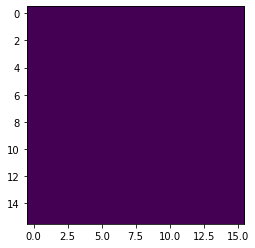

In [3]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(16
                        , 2, 4, 2, False,False,2,False,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

In [16]:
print('z')

z


In [4]:
def print_policy(Q_policy, env, val_1, val_2):
    val_2=0
    val_1=0
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[y * el + j2] = a[1][0] * (el/env.manager_view*(env.n_layers-1)) + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    value_list = {}
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
    #     this is used to find task
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')
    return j1v,j2v

In [3]:



# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 6000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}
env1=copy.copy(env)

device = torch.device("cpu")
for num_hidden_mult in [2]:
    for man_init in ['Exact','Init','Learn','Nil']:
        for length in [7]:
        #     for num_hidden in  [int(n_input*1.1)]:
        # counter=0
            n_input = 2*length ** 2 + 8

            for num_hidden in  [int(num_hidden_mult*length ** 2)]:
                clear_output(wait=True)
        #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
        #     for length in [3]:
                memory = ReplayMemory(1)



                Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
                Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

                # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
                # Q_target = QNetwork(n_input, num_hidden, device).to(device)

                # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
                # target_net = DQN(screen_height, screen_width, n_actions).to(device)
                Q_target.load_state_dict(Q_policy.state_dict())
                Q_target.eval()
                allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

                policy = EpsilonGreedyPolicy(Q_policy, 0.08)

                episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                      batch_size,
                                                                      discount_factor, learn_rate, np.minimum(500,num_episodes))
                r_dict_3[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                                 'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
                counter=counter+1
        #         import matplotlib.pyplot as plt
        #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






NameError: name 'env' is not defined

  0%|                                                                              | 1/6000 [00:30<51:23:56, 30.84s/it]

epsilon 0.75


  1%|▋                                                                             | 51/6000 [05:45<5:31:58,  3.35s/it]

epsilon 0.73875


  2%|█▎                                                                           | 101/6000 [10:58<5:06:26,  3.12s/it]

epsilon 0.7275


  3%|█▉                                                                           | 151/6000 [15:32<8:28:32,  5.22s/it]

epsilon 0.71625


  3%|██▌                                                                          | 201/6000 [18:44<4:27:42,  2.77s/it]

epsilon 0.705


  4%|███▏                                                                         | 252/6000 [21:48<5:52:44,  3.68s/it]

epsilon 0.69375


  5%|███▊                                                                         | 301/6000 [24:14<4:15:57,  2.69s/it]

epsilon 0.6825


  6%|████▌                                                                        | 351/6000 [27:30<7:15:38,  4.63s/it]

epsilon 0.67125
[278.1933333333333]
min mean 278.1933333333333
last mean 350    283.046667
dtype: float64


  7%|█████                                                                       | 400/6000 [32:04<14:46:12,  9.50s/it]

epsilon 0.66
[278.1933333333333, 260.1766666666667]
min mean 260.1766666666667
last mean 400    275.34
dtype: float64


  8%|█████▊                                                                       | 451/6000 [39:14<6:52:06,  4.46s/it]

epsilon 0.6487499999999999
[278.1933333333333, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 450    309.066667
dtype: float64


  8%|██████▍                                                                      | 501/6000 [44:29<5:50:48,  3.83s/it]

epsilon 0.6375
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 500    335.686667
dtype: float64


  9%|███████                                                                      | 551/6000 [51:19<9:37:48,  6.36s/it]

epsilon 0.62625
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 550    381.106667
dtype: float64


 10%|███████▌                                                                    | 601/6000 [57:51<10:14:26,  6.83s/it]

epsilon 0.615
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 600    436.026667
dtype: float64


 11%|████████▏                                                                  | 651/6000 [1:02:36<4:16:36,  2.88s/it]

epsilon 0.60375
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 650    459.123333
dtype: float64


 12%|████████▊                                                                  | 701/6000 [1:07:11<4:23:53,  2.99s/it]

epsilon 0.5925
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 700    460.793333
dtype: float64


 13%|█████████▍                                                                 | 751/6000 [1:10:34<5:48:46,  3.99s/it]

epsilon 0.58125
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 750    415.503333
dtype: float64


 13%|██████████                                                                 | 801/6000 [1:13:56<7:59:42,  5.54s/it]

epsilon 0.5700000000000001
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 800    393.223333
dtype: float64


 14%|██████████▋                                                                | 851/6000 [1:16:25<3:55:49,  2.75s/it]

epsilon 0.55875
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 850    341.62
dtype: float64


 15%|███████████▎                                                               | 901/6000 [1:20:01<3:23:12,  2.39s/it]

epsilon 0.5475
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 900    304.95
dtype: float64


 16%|███████████▉                                                               | 951/6000 [1:22:30<8:21:20,  5.96s/it]

epsilon 0.53625
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667]
min mean 260.1766666666667
last mean 950    274.643333
dtype: float64


 17%|████████████▎                                                             | 1001/6000 [1:24:20<3:48:32,  2.74s/it]

epsilon 0.525
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42]
min mean 237.42
last mean 1000    237.756667
dtype: float64


 18%|████████████▉                                                             | 1051/6000 [1:26:13<2:53:05,  2.10s/it]

epsilon 0.5137499999999999
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334]
min mean 216.27333333333334
last mean 1050    216.763333
dtype: float64


 18%|█████████████▌                                                            | 1101/6000 [1:28:03<5:09:47,  3.79s/it]

epsilon 0.5025
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332]
min mean 194.57333333333332
last mean 1100    195.616667
dtype: float64


 19%|██████████████▏                                                           | 1151/6000 [1:29:50<2:29:25,  1.85s/it]

epsilon 0.49125
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332]
min mean 185.82333333333332
last mean 1150    185.863333
dtype: float64


 20%|██████████████▊                                                           | 1201/6000 [1:31:39<4:57:22,  3.72s/it]

epsilon 0.48
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334]
min mean 158.61333333333334
last mean 1200    160.693333
dtype: float64


 21%|███████████████▍                                                          | 1251/6000 [1:33:38<3:45:18,  2.85s/it]

epsilon 0.46875
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46]
min mean 154.46
last mean 1250    154.46
dtype: float64


 22%|████████████████                                                          | 1301/6000 [1:35:26<2:55:46,  2.24s/it]

epsilon 0.4575
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333]
min mean 152.50333333333333
last mean 1300    154.9
dtype: float64


 23%|████████████████▋                                                         | 1351/6000 [1:37:32<4:11:41,  3.25s/it]

epsilon 0.44625
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666]
min mean 151.81666666666666
last mean 1350    159.943333
dtype: float64


 23%|█████████████████▎                                                        | 1401/6000 [1:39:27<3:57:40,  3.10s/it]

epsilon 0.435
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666]
min mean 151.81666666666666
last mean 1400    162.106667
dtype: float64


 24%|█████████████████▉                                                        | 1451/6000 [1:41:17<3:00:33,  2.38s/it]

epsilon 0.42375
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666]
min mean 151.81666666666666
last mean 1450    162.883333
dtype: float64


 25%|██████████████████▌                                                       | 1501/6000 [1:42:26<2:02:17,  1.63s/it]

epsilon 0.4125
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666]
min mean 151.81666666666666
last mean 1500    153.56
dtype: float64


 26%|███████████████████▏                                                      | 1551/6000 [1:43:34<2:03:43,  1.67s/it]

epsilon 0.40125
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665]
min mean 141.54666666666665
last mean 1550    141.546667
dtype: float64


 27%|███████████████████▋                                                      | 1601/6000 [1:44:49<2:19:38,  1.90s/it]

epsilon 0.39
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667]
min mean 133.30666666666667
last mean 1600    133.366667
dtype: float64


 28%|████████████████████▎                                                     | 1651/6000 [1:45:51<1:29:42,  1.24s/it]

epsilon 0.37875000000000003
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52]
min mean 117.52
last mean 1650    117.52
dtype: float64


 28%|████████████████████▉                                                     | 1701/6000 [1:47:00<1:21:07,  1.13s/it]

epsilon 0.3675
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22]
min mean 106.22
last mean 1700    106.22
dtype: float64


 29%|██████████████████████▏                                                     | 1750/6000 [1:47:38<57:50,  1.22it/s]

epsilon 0.35624999999999996
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75]
min mean 89.75
last mean 

 29%|█████████████████████▌                                                    | 1751/6000 [1:47:40<1:15:29,  1.07s/it]

1750    89.75
dtype: float64


 30%|██████████████████████▏                                                   | 1801/6000 [1:48:13<1:07:09,  1.04it/s]

epsilon 0.345
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333]
min mean 81.37333333333333
last mean 1800    81.39
dtype: float64


 31%|███████████████████████▍                                                    | 1851/6000 [1:48:40<35:46,  1.93it/s]

epsilon 0.33375
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333]
min mean 71.72333333333333
last mean 1850    71.723333
dtype: float64


 32%|████████████████████████                                                    | 1901/6000 [1:49:04<39:10,  1.74it/s]

epsilon 0.3225
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334]
min mean 59.413333333333334
last mean 1900    59.413333
dtype: float64


 33%|████████████████████████▋                                                   | 1951/6000 [1:49:32<37:07,  1.82it/s]

epsilon 0.31125
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78]
min mean 50.78
last mean 1950    50.78
dtype: float64


 33%|█████████████████████████▎                                                  | 2001/6000 [1:49:57<25:05,  2.66it/s]

epsilon 0.30000000000000004
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38]
min mean 40.38
last mean 2000    40.43
dtype: float64


 34%|█████████████████████████▉                                                  | 2051/6000 [1:50:21<21:45,  3.03it/s]

epsilon 0.28875
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59]
min mean 36.59
last mean 2050    36.59
dtype: float64


 35%|██████████████████████████▌                                                 | 2101/6000 [1:50:46<22:34,  2.88it/s]

epsilon 0.27749999999999997
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55]
min mean 34.55
last mean 2100    34.646667
dtype: float64


 36%|███████████████████████████▏                                                | 2151/6000 [1:51:12<40:47,  1.57it/s]

epsilon 0.26625
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667]
min mean 33.47666666666667
last mean 2150    34.33
dtype: float64


 37%|███████████████████████████▉                                                | 2201/6000 [1:51:40<24:55,  2.54it/s]

epsilon 0.255
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667]
min mean 33.47666666666667
last mean 2200    35.86
dtype: float64


 38%|████████████████████████████▌                                               | 2252/6000 [1:52:00<17:54,  3.49it/s]

epsilon 0.2437499999999999
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667]
min mean 33.47666666666667
last mean 2250    33.87
dtype: float64


 38%|█████████████████████████████▏                                              | 2301/6000 [1:52:21<23:03,  2.67it/s]

epsilon 0.23250000000000004
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335]
min mean 32.693333333333335
last mean 2300    33.066667
dtype: float64


 39%|█████████████████████████████▊                                              | 2351/6000 [1:52:41<26:16,  2.31it/s]

epsilon 0.22125000000000006
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665]
min mean 32.126666666666665
last mean 2350    32.23
dtype: float64


 40%|██████████████████████████████▍                                             | 2401/6000 [1:53:02<37:07,  1.62it/s]

epsilon 0.20999999999999996
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7]
min mean 30.7
last mean 2400    31.276667
dtype: float64


 41%|███████████████████████████████                                             | 2451/6000 [1:53:23<18:37,  3.18it/s]

epsilon 0.19874999999999998
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666]
min mean 30.016666666666666
last mean 2450    30.016667
dtype: float64


 42%|███████████████████████████████▋                                            | 2502/6000 [1:53:45<13:52,  4.20it/s]

epsilon 0.1875
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51]
min mean 28.51
last mean 2500    28.55
dtype: float64


 43%|████████████████████████████████▎                                           | 2551/6000 [1:54:03<23:38,  2.43it/s]

epsilon 0.17625000000000002
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0]
min mean 28.0
last mean 2550    28.133333
dtype: float64


 43%|████████████████████████████████▉                                           | 2601/6000 [1:54:24<22:43,  2.49it/s]

epsilon 0.16500000000000004
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0]
min mean 28.0
last mean 2600    28.216667
dtype: float64


 44%|█████████████████████████████████▌                                          | 2651/6000 [1:54:41<20:37,  2.71it/s]

epsilon 0.15374999999999994
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27]
min mean 27.27
last mean 2650    27.443333
dtype: float64


 45%|██████████████████████████████████▏                                         | 2701/6000 [1:55:00<18:56,  2.90it/s]

epsilon 0.14249999999999996
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27]
min mean 27.27
last mean 2700    27.306667
dtype: float64


 46%|██████████████████████████████████▊                                         | 2751/6000 [1:55:21<45:17,  1.20it/s]

epsilon 0.1312500000000001
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332]
min mean 26.583333333333332
last mean 2750    27.603333
dtype: float64


 47%|███████████████████████████████████▍                                        | 2801/6000 [1:55:39<24:51,  2.14it/s]

epsilon 0.12
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75]
min mean 25.75
last mean 2800    26.766667
dtype: float64


 48%|████████████████████████████████████▏                                       | 2852/6000 [1:55:58<19:47,  2.65it/s]

epsilon 0.10875000000000001
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75]
min mean 25.75
last mean 2850    27.476667
dtype: float64


 48%|████████████████████████████████████▋                                       | 2901/6000 [1:56:17<22:43,  2.27it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75]
min mean 25.75
last mean 2900    27.15
dtype: float64


 49%|█████████████████████████████████████▍                                      | 2951/6000 [1:56:36<20:46,  2.45it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75]
min mean 25.75
last mean 2950    27.89
dtype: float64


 50%|██████████████████████████████████████                                      | 3002/6000 [1:56:58<17:22,  2.88it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75]
min mean 25.75
last mean 3000    28.356667
dtype: float64


 51%|██████████████████████████████████████▋                                     | 3051/6000 [1:57:14<23:33,  2.09it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75]
min mean 25.75
last mean 3050    27.073333
dtype: float64


 52%|███████████████████████████████████████▎                                    | 3101/6000 [1:57:29<18:07,  2.66it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75]
min mean 25.75
last mean 3100    26.29
dtype: float64


 52%|███████████████████████████████████████▉                                    | 3150/6000 [1:57:45<11:24,  4.16it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09]
min mean 25.09
last mean 3150    25.096667
dtype: float64


 53%|████████████████████████████████████████▌                                   | 3201/6000 [1:58:04<21:20,  2.19it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666]
min mean 24.906666666666666
last mean 3200    25.013333
dtype: float64


 54%|█████████████████████████████████████████▏                                  | 3251/6000 [1:58:20<25:48,  1.78it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667]
min mean 23.616666666666667
last mean 3250    24.276667
dtype: float64


 55%|█████████████████████████████████████████▊                                  | 3300/6000 [1:58:32<12:07,  3.71it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332]
min mean 21.903333333333332
last mean 3300    21.903333
dtype: float64


 56%|██████████████████████████████████████████▍                                 | 3352/6000 [1:58:52<11:10,  3.95it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7]
min mean 21.7
last mean 3350    22.63
dtype: float64


 57%|███████████████████████████████████████████                                 | 3402/6000 [1:59:05<08:00,  5.40it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7]
min mean 21.7
last mean 3400    22.196667
dtype: float64


 58%|███████████████████████████████████████████▋                                | 3451/6000 [1:59:20<11:43,  3.62it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332]
min mean 21.403333333333332
last mean 3450    22.146667
dtype: float64


 58%|████████████████████████████████████████████▎                               | 3501/6000 [1:59:40<16:22,  2.54it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335]
min mean 21.123333333333335
last mean 3500    22.70

 59%|████████████████████████████████████████████▉                               | 3551/6000 [1:59:59<15:11,  2.69it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335]
min mean 21.123333333333335
las

 60%|█████████████████████████████████████████████▋                              | 3602/6000 [2:00:16<10:24,  3.84it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335]
min mean 21

 61%|██████████████████████████████████████████████▏                             | 3651/6000 [2:00:32<13:58,  2.80it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 62%|██████████████████████████████████████████████▉                             | 3701/6000 [2:00:49<10:04,  3.80it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 63%|███████████████████████████████████████████████▌                            | 3751/6000 [2:01:04<13:30,  2.77it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 63%|████████████████████████████████████████████████▏                           | 3801/6000 [2:01:21<11:59,  3.06it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 64%|████████████████████████████████████████████████▊                           | 3852/6000 [2:01:38<07:12,  4.97it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 65%|█████████████████████████████████████████████████▍                          | 3902/6000 [2:01:58<11:05,  3.15it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 66%|██████████████████████████████████████████████████                          | 3951/6000 [2:02:16<13:30,  2.53it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 67%|██████████████████████████████████████████████████▋                         | 4001/6000 [2:02:28<13:28,  2.47it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 68%|███████████████████████████████████████████████████▎                        | 4051/6000 [2:02:47<13:00,  2.50it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 68%|███████████████████████████████████████████████████▉                        | 4100/6000 [2:03:03<09:53,  3.20it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 69%|████████████████████████████████████████████████████▌                       | 4151/6000 [2:03:21<13:34,  2.27it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 70%|█████████████████████████████████████████████████████▏                      | 4201/6000 [2:03:35<07:09,  4.19it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 71%|█████████████████████████████████████████████████████▊                      | 4251/6000 [2:03:55<10:26,  2.79it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 72%|██████████████████████████████████████████████████████▍                     | 4301/6000 [2:04:09<10:32,  2.69it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 73%|███████████████████████████████████████████████████████                     | 4351/6000 [2:04:26<09:36,  2.86it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 73%|███████████████████████████████████████████████████████▊                    | 4402/6000 [2:04:44<05:11,  5.13it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 74%|████████████████████████████████████████████████████████▍                   | 4451/6000 [2:04:58<07:26,  3.47it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 75%|█████████████████████████████████████████████████████████                   | 4501/6000 [2:05:17<11:56,  2.09it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 76%|█████████████████████████████████████████████████████████▋                  | 4551/6000 [2:05:36<09:40,  2.49it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 77%|██████████████████████████████████████████████████████████▎                 | 4601/6000 [2:05:59<08:37,  2.70it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 78%|██████████████████████████████████████████████████████████▉                 | 4650/6000 [2:06:22<10:16,  2.19it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 78%|███████████████████████████████████████████████████████████▌                | 4701/6000 [2:06:49<08:56,  2.42it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 79%|████████████████████████████████████████████████████████████▏               | 4750/6000 [2:07:14<18:21,  1.13it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 80%|████████████████████████████████████████████████████████████▊               | 4801/6000 [2:07:33<09:54,  2.02it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 81%|█████████████████████████████████████████████████████████████▍              | 4851/6000 [2:07:56<10:26,  1.83it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 82%|██████████████████████████████████████████████████████████████              | 4901/6000 [2:08:23<09:15,  1.98it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 83%|██████████████████████████████████████████████████████████████▋             | 4951/6000 [2:08:50<04:42,  3.72it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 83%|███████████████████████████████████████████████████████████████▎            | 5001/6000 [2:09:12<05:11,  3.21it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 84%|███████████████████████████████████████████████████████████████▉            | 5051/6000 [2:09:34<09:29,  1.67it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 85%|████████████████████████████████████████████████████████████████▌           | 5101/6000 [2:09:58<09:25,  1.59it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 86%|█████████████████████████████████████████████████████████████████▏          | 5151/6000 [2:10:21<08:49,  1.60it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 87%|█████████████████████████████████████████████████████████████████▉          | 5201/6000 [2:10:44<12:40,  1.05it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 88%|██████████████████████████████████████████████████████████████████▌         | 5252/6000 [2:11:09<05:47,  2.15it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 88%|███████████████████████████████████████████████████████████████████▏        | 5301/6000 [2:11:29<05:57,  1.96it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 89%|███████████████████████████████████████████████████████████████████▊        | 5351/6000 [2:11:49<04:51,  2.22it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 90%|████████████████████████████████████████████████████████████████████▍       | 5402/6000 [2:12:08<02:19,  4.27it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 91%|█████████████████████████████████████████████████████████████████████       | 5451/6000 [2:12:26<04:17,  2.13it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 92%|█████████████████████████████████████████████████████████████████████▋      | 5501/6000 [2:12:44<03:08,  2.64it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 93%|██████████████████████████████████████████████████████████████████████▎     | 5551/6000 [2:13:09<03:03,  2.45it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 93%|██████████████████████████████████████████████████████████████████████▉     | 5602/6000 [2:13:31<01:29,  4.44it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 94%|███████████████████████████████████████████████████████████████████████▌    | 5651/6000 [2:13:50<01:13,  4.77it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 95%|████████████████████████████████████████████████████████████████████████▏   | 5701/6000 [2:14:10<02:52,  1.73it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 96%|████████████████████████████████████████████████████████████████████████▊   | 5751/6000 [2:14:32<02:28,  1.68it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 97%|█████████████████████████████████████████████████████████████████████████▍  | 5801/6000 [2:14:48<01:11,  2.80it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 98%|██████████████████████████████████████████████████████████████████████████  | 5851/6000 [2:15:06<00:33,  4.45it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 98%|██████████████████████████████████████████████████████████████████████████▋ | 5901/6000 [2:15:28<00:23,  4.23it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

 99%|███████████████████████████████████████████████████████████████████████████▍| 5951/6000 [2:15:47<00:20,  2.44it/s]

epsilon 0.1
[278.1933333333333, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 260.1766666666667, 237.42, 216.27333333333334, 194.57333333333332, 185.82333333333332, 158.61333333333334, 154.46, 152.50333333333333, 151.81666666666666, 151.81666666666666, 151.81666666666666, 151.81666666666666, 141.54666666666665, 133.30666666666667, 117.52, 106.22, 89.75, 81.37333333333333, 71.72333333333333, 59.413333333333334, 50.78, 40.38, 36.59, 34.55, 33.47666666666667, 33.47666666666667, 33.47666666666667, 32.693333333333335, 32.126666666666665, 30.7, 30.016666666666666, 28.51, 28.0, 28.0, 27.27, 27.27, 26.583333333333332, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.75, 25.09, 24.906666666666666, 23.616666666666667, 21.903333333333332, 21.7, 21.7, 21.403333333333332, 21.123333333333335, 21.123333333333335, 21.123333333333335, 21.12333333

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [2:16:07<00:00,  1.36s/it]


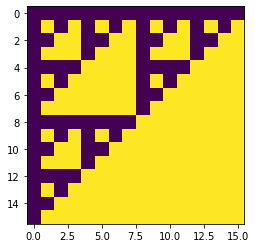

In [12]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(16
                        , 2, 4, 2, False,True,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 6000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_4={}
env2=copy.copy(env)
device = torch.device("cpu")

for man_init in ['Init','Nil','Exact','Learn']:
    print(man_init)
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_4[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards),'ss':copy.copy(ss) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[3, 12]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.]]


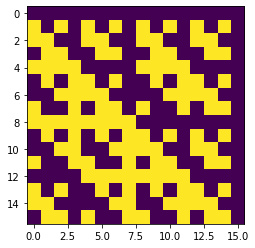

In [5]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(16
                        , 2, 4, 2, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_5={}

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 6000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env3=copy.copy(env)

In [9]:
counter

4

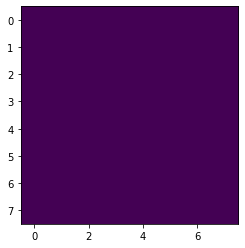

In [23]:
plt.imshow(env.maze)

In [22]:
r_d

dict_keys([0, 1, 2, 3])

In [11]:
# r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                              'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
# counter=counter+1

In [ ]:


for man_init in ['Learn']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
            print(man_init)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

Learn


C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:478: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:363: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|                                                                              | 1/6000 [00:32<54:38:44, 32.79s/it]

epsilon 0.75


  1%|▋                                                                             | 51/6000 [04:09<6:01:38,  3.65s/it]

epsilon 0.73875


  2%|█▎                                                                           | 101/6000 [06:39<3:11:48,  1.95s/it]

epsilon 0.7275


  3%|█▉                                                                           | 151/6000 [08:28<5:48:18,  3.57s/it]

epsilon 0.71625


  3%|██▌                                                                          | 201/6000 [09:47<2:24:05,  1.49s/it]

epsilon 0.705


  4%|███▏                                                                         | 251/6000 [11:18<3:13:18,  2.02s/it]

epsilon 0.69375


  5%|███▊                                                                         | 301/6000 [12:36<4:06:40,  2.60s/it]

epsilon 0.6825


  6%|████▌                                                                        | 351/6000 [13:53<3:57:09,  2.52s/it]

epsilon 0.67125
[181.11]
min mean 181.11
last mean 350    181.11
dtype: float64


  7%|█████▏                                                                       | 401/6000 [15:14<2:46:50,  1.79s/it]

epsilon 0.66
[181.11, 158.41333333333333]
min mean 158.41333333333333
last mean 400    158.98
dtype: float64


  8%|█████▊                                                                       | 451/6000 [16:21<2:28:42,  1.61s/it]

epsilon 0.6487499999999999
[181.11, 158.41333333333333, 144.48666666666668]
min mean 144.48666666666668
last mean 450    144.486667
dtype: float64


  8%|██████▍                                                                      | 501/6000 [17:29<2:13:27,  1.46s/it]

epsilon 0.6375
[181.11, 158.41333333333333, 144.48666666666668, 139.56]
min mean 139.56
last mean 500    140.183333
dtype: float64


  9%|███████                                                                      | 551/6000 [18:29<1:18:56,  1.15it/s]

epsilon 0.62625
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666]
min mean 129.41666666666666
last mean 550    129.416667
dtype: float64


 10%|███████▋                                                                     | 601/6000 [19:15<1:05:52,  1.37it/s]

epsilon 0.615
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333]
min mean 118.50333333333333
last mean 600    118.503333
dtype: float64


 11%|████████▎                                                                    | 651/6000 [19:57<1:37:03,  1.09s/it]

epsilon 0.60375
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334]
min mean 107.54333333333334
last mean 650    107.543333
dtype: float64


 12%|████████▉                                                                    | 701/6000 [20:45<1:04:56,  1.36it/s]

epsilon 0.5925
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667]
min mean 97.52666666666667
last mean 700    97.526667
dtype: float64


 13%|█████████▋                                                                   | 751/6000 [21:35<1:24:23,  1.04it/s]

epsilon 0.58125
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7]
min mean 91.7
last mean 750    92.153333
dtype: float64


 13%|██████████▌                                                                    | 801/6000 [22:04<40:02,  2.16it/s]

epsilon 0.5700000000000001
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5]
min mean 80.5
last mean 800    80.5
dtype: float64


 14%|██████████▉                                                                  | 851/6000 [22:52<1:04:58,  1.32it/s]

epsilon 0.55875
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667]
min mean 75.65666666666667
last mean 850    76.2
dtype: float64


 15%|███████████▌                                                                 | 901/6000 [23:29<1:42:48,  1.21s/it]

epsilon 0.5475
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97]
min mean 72.97
last mean 900    73.923333
dtype: float64


 16%|████████████▌                                                                  | 951/6000 [24:05<41:59,  2.00it/s]

epsilon 0.53625
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333]
min mean 71.81333333333333
last mean 950    71.913333
dtype: float64


 17%|████████████▋                                                               | 1001/6000 [24:37<1:07:13,  1.24it/s]

epsilon 0.525
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333]
min mean 66.06333333333333
last mean 1000    66.4
dtype: float64


 18%|█████████████▎                                                              | 1051/6000 [25:12<1:19:43,  1.03it/s]

epsilon 0.5137499999999999
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336]
min mean 61.473333333333336
last mean 1050    61.603333
dtype: float64


 18%|██████████████▎                                                               | 1101/6000 [25:39<40:53,  2.00it/s]

epsilon 0.5025
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333]
min mean 60.02333333333333
last mean 1100    60.16
dtype: float64


 19%|██████████████▉                                                               | 1152/6000 [26:09<51:26,  1.57it/s]

epsilon 0.49125
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666]
min mean 54.406666666666666
last mean 1150    54.733333
dtype: float64


 20%|███████████████▌                                                              | 1201/6000 [26:37<35:14,  2.27it/s]

epsilon 0.48
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43]
min mean 51.43
last mean 1200    51.43
dtype: float64


 21%|████████████████▎                                                             | 1251/6000 [27:08<33:44,  2.35it/s]

epsilon 0.46875
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334]
min mean 48.61333333333334
last mean 1250    49.606667
dtype: float64


 22%|████████████████▉                                                             | 1301/6000 [27:38<59:29,  1.32it/s]

epsilon 0.4575
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334]
min mean 48.61333333333334
last mean 1300    49.876667
dtype: float64


 23%|█████████████████▌                                                            | 1351/6000 [27:59<25:04,  3.09it/s]

epsilon 0.44625
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336]
min mean 46.083333333333336
last mean 1350    46.083333
dtype: float64


 23%|██████████████████▏                                                           | 1401/6000 [28:27<30:22,  2.52it/s]

epsilon 0.435
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336]
min mean 46.083333333333336
last mean 1400    46.733333
dtype: float64


 24%|██████████████████▊                                                           | 1450/6000 [28:49<41:21,  1.83it/s]

epsilon 0.42375
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335]
min mean 45.013333333333335
last mean 1450    45.013333
dtype: float64


 25%|███████████████████▌                                                          | 1501/6000 [29:11<38:10,  1.96it/s]

epsilon 0.4125
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06]
min mean 42.06
last mean 1500    42.203333
dtype: float64


 26%|████████████████████▏                                                         | 1551/6000 [29:42<50:54,  1.46it/s]

epsilon 0.40125
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35]
min mean 40.35
last mean 1550    40.61
dtype: float64


 27%|████████████████████▊                                                         | 1601/6000 [30:06<29:14,  2.51it/s]

epsilon 0.39
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667]
min mean 37.00666666666667
last mean 1600    37.04
dtype: float64


 28%|█████████████████████▍                                                        | 1650/6000 [30:23<39:37,  1.83it/s]

epsilon 0.37875000000000003
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82]
min mean 35.82
last mean 1650    36.313333
dtype: float64


 28%|██████████████████████                                                        | 1701/6000 [30:42<18:20,  3.91it/s]

epsilon 0.3675
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333]
min mean 34.10333333333333
last mean 1700    34.17
dtype: float64


 29%|██████████████████████▊                                                       | 1751/6000 [30:57<22:28,  3.15it/s]

epsilon 0.35624999999999996
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667]
min mean 32.06666666666667
last mean 1750    32.25
dtype: float64


 30%|███████████████████████▍                                                      | 1801/6000 [31:14<27:41,  2.53it/s]

epsilon 0.345
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666]
min mean 32.016666666666666
last mean 1800    32.343333
dtype: float64


 31%|████████████████████████                                                      | 1851/6000 [31:26<18:20,  3.77it/s]

epsilon 0.33375
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53]
min mean 28.53
last mean 1850    28.53
dtype: float64


 32%|████████████████████████▋                                                     | 1901/6000 [31:46<27:56,  2.45it/s]

epsilon 0.3225
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334]
min mean 28.503333333333334
last mean 1900    29.643333
dtype: float64


 33%|█████████████████████████▎                                                    | 1951/6000 [32:02<16:16,  4.15it/s]

epsilon 0.31125
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334, 28.503333333333334]
min mean 28.503333333333334
last mean 1950    29.243333
dtype: float64


 33%|██████████████████████████                                                    | 2001/6000 [32:17<25:46,  2.59it/s]

epsilon 0.30000000000000004
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334, 28.503333333333334, 27.976666666666667]
min mean 27.976666666666667
last mean 2000    28.16
dtype: float64


 34%|██████████████████████████▋                                                   | 2051/6000 [32:33<20:47,  3.17it/s]

epsilon 0.28875
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334, 28.503333333333334, 27.976666666666667, 27.8]
min mean 27.8
last mean 2050    28.373333
dtype: float64


 35%|███████████████████████████▎                                                  | 2102/6000 [32:49<12:03,  5.39it/s]

epsilon 0.27749999999999997
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334, 28.503333333333334, 27.976666666666667, 27.8, 27.8]
min mean 27.8
last mean 2100    28.2
dtype: float64


 36%|███████████████████████████▉                                                  | 2152/6000 [33:03<13:29,  4.76it/s]

epsilon 0.26625
[181.11, 158.41333333333333, 144.48666666666668, 139.56, 129.41666666666666, 118.50333333333333, 107.54333333333334, 97.52666666666667, 91.7, 80.5, 75.65666666666667, 72.97, 71.81333333333333, 66.06333333333333, 61.473333333333336, 60.02333333333333, 54.406666666666666, 51.43, 48.61333333333334, 48.61333333333334, 46.083333333333336, 46.083333333333336, 45.013333333333335, 42.06, 40.35, 37.00666666666667, 35.82, 34.10333333333333, 32.06666666666667, 32.016666666666666, 28.53, 28.503333333333334, 28.503333333333334, 27.976666666666667, 27.8, 27.8, 27.8]
min mean 27.8
last mean 2150    28.92
dtype: float64


 36%|████████████████████████████                                                  | 2156/6000 [33:03<14:49,  4.32it/s]

In [13]:
# r_dict_5.keys()

In [21]:
r_dict_4.keys()

dict_keys([0, 1, 2, 3])

Exact
QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
)
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'S' 'S' 'S']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'W' 'W']
 ['N' 'N' 'W' 'N']]
[[list([(0, -2.941380500793457), (1, -2.0082669258117676), (2, -2.309081554412842), (3, -3.4747672080993652)])
  list([(0, -1.191685676574707), (1, -0.09035239368677139), (2, -4.202871322631836), (3, -3.342308521270752)])
  list([(0, -4.467220306396484), (1, -1.9474971294403076), (2, -5.784989833831787

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'N' 'N' 'N' 'N']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W' 'N' 'N' 'N' 

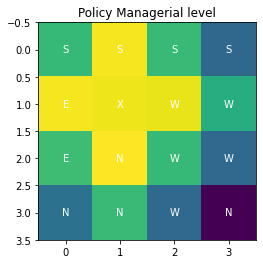

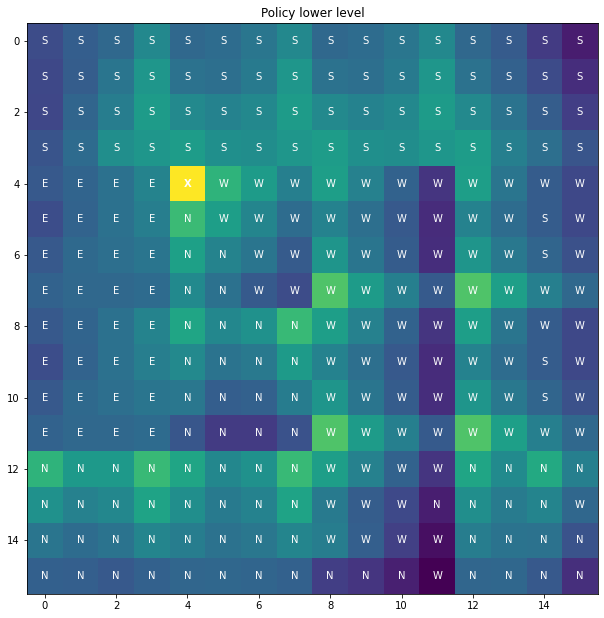

cccc
Init
QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
)
Parameter containing:
tensor([[0.8758, 1.9650, 4.0380]], requires_grad=True) Parameter containing:
tensor([0.])
[0.8757765889167786, 1.965019941329956, 4.037965297698975]
Ratio M/L: 2.054923317961861
[['S' 'S' 'S' 'S']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'W' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -3.090418815612793), (1, -2.2157487869262695), (2, -2.8641304969787598), (3, -3.1959147453308105)])
  list([(0, -1.0884562730789185), (1, 0.07766260951757431), (2, -4.358652591705322), (3, -3.068036

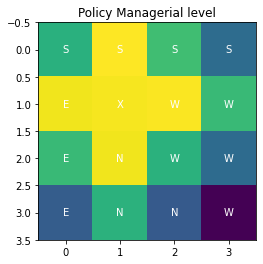

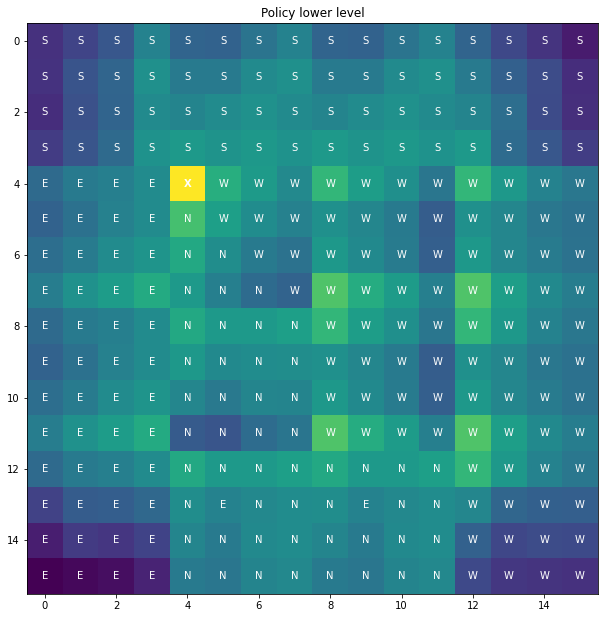

cccc
Learn
QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
)
Parameter containing:
tensor([[ 0.2965, -0.4971, -0.9510]], requires_grad=True) Parameter containing:
tensor([-0.5351], requires_grad=True)
[-0.23864644765853882, -1.0322637557983398, -1.486156940460205]
Ratio M/L: 1.439706598349789
[['S' 'S' 'S' 'S']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'N' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -4.5780558586120605), (1, -1.8166166543960571), (2, -1.9070335626602173), (3, -3.0882785320281982)])
  list([(0, -2.6464695930480957), (1, 0.20528261363506317), (2,

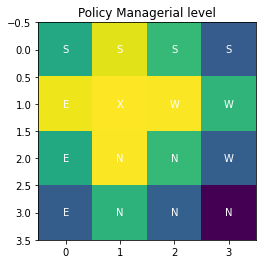

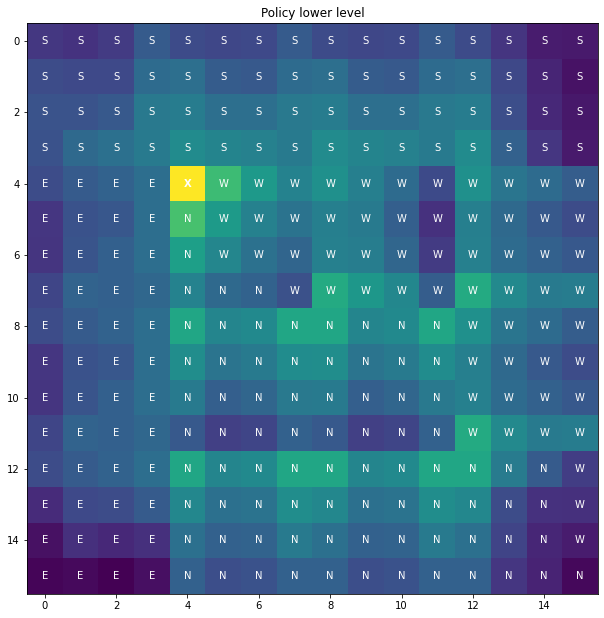

cccc
Nil
QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
)
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'W' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -5.023880958557129), (1, -2.2876341342926025), (2, -2.3833818435668945), (3, -4.167825222015381)])
  list([(0, -2.849531412124634), (1, -0.13225750625133514), (2, -3.9914135932922363), (3, -2.9271185398101807)])
  list([(0, -5.96714973449707), (1, -1.7062574625015259), (2, -4.75810861587

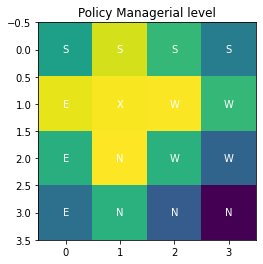

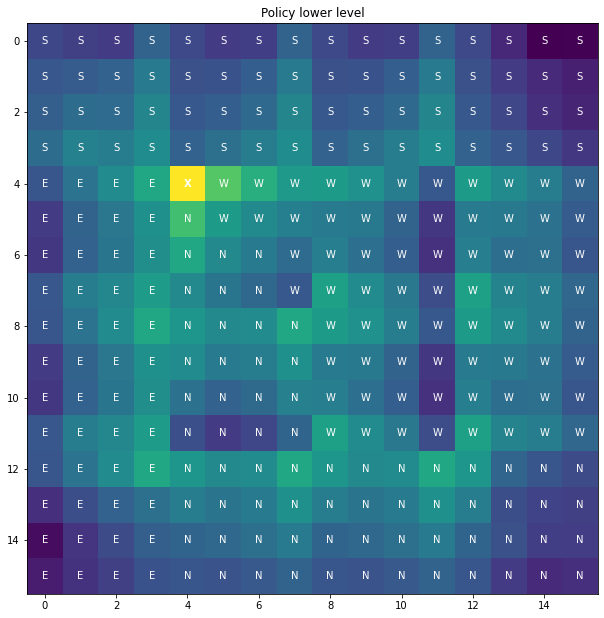

cccc
Exact 11.14
Init 10.99
Learn 11.1
Nil 10.88


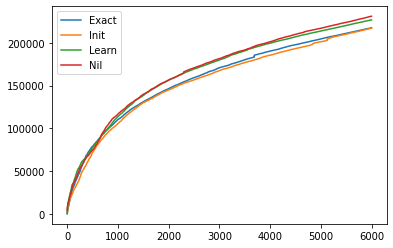

Exact 11.14
Init 10.99
Learn 11.1
Nil 10.88


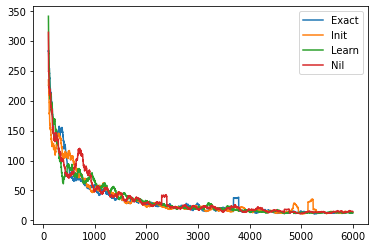

Exact -49.74
Init -51.39
Learn -53.52
Nil -55.92


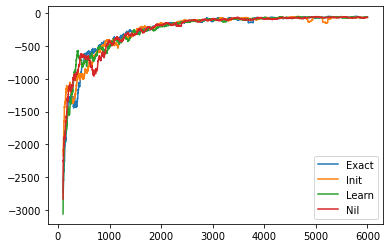

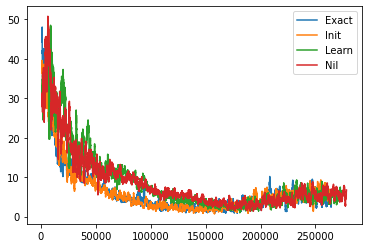

In [36]:
r=4
des='man_init'
man_inits=['Exact','Init','Learn','Nil']
qs={}
for x1 in range(r):
    
    labelp=man_inits[x1]
    nn=r_dict_3[x1]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn)
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    j1v,j2v=print_policy(nn, env1, 0, 0)
    
    rewards_v,rewards_h,man_true_q_avg,man_true_q_max,man_true_q_min=get_true_q(env1,nn)
    qs[x1]={'v1':j1v,'v2':j2v,'vt1':rewards_v,'vth':rewards_h,'vt_avg':man_true_q_avg,'vt_max':man_true_q_max,'vt_min':man_true_q_min}
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(r):
    labelp=man_inits[x]
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).expanding().sum().plot(label=labelp)
plt.legend()
plt.show()
for x in range(r):
    labelp=man_inits[x]
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(r):
    labelp=man_inits[x]
    print(labelp,pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(r):
    labelp=man_inits[x]
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

In [26]:
x1

0

[-2,
 -1,
 -2,
 -1,
 -2,
 -2,
 -2,
 -2,
 -2,
 -1,
 -2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -2,
 -1,
 -2,
 -1,
 -2,
 -3,
 -2,
 -2,
 -2,
 -1,
 -2,
 -1,
 -1,
 -2,
 -1,
 -1,
 -2,
 -1,
 -2,
 -1,
 0,
 -1,
 -1,
 -2,
 -2,
 -1,
 -3,
 -2,
 -1,
 -2,
 -1,
 -2,
 -2,
 -1,
 -2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -2,
 -1,
 -2,
 -1,
 -2,
 -2,
 -2,
 -2]

In [37]:
rmse={}
for i,l in enumerate(man_inits):
    print(l)
    diff_2=np.sqrt(np.mean((np.array(qs[i]['v2'])-np.array([x for x in qs[i]['vt1'].values()]))**2))
#     print(diff)
    
    diff_avg=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_avg'].values()]))**2))
#     print(diff)
    diff_max=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_max'].values()]))**2))
    diff_min=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_min'].values()]))**2))

    rmse[l]={'Diff_avg':diff_avg,'Diff_max':diff_max,'Diff_min':diff_min,'Diff_agent':diff_2}

pd.DataFrame(rmse)  

Exact
Init
Learn
Nil


Exact      Init     Learn       Nil
Diff_avg    4.041859  3.913514  4.353739  4.212348
Diff_max    1.818338  1.763827  2.194660  2.091317
Diff_min    6.609923  6.282373  6.701198  6.551843
Diff_agent  1.794527  2.959002  2.423974  2.816721

In [6]:
def get_true_q(env,Q_policy):
    rewards_v={}
    rewards_h={}
    for s in range(int(env.maze.shape[0]**2)):
    #     print(s)
        d=False
        rewards_v[s]=0
        rewards_h[s]=0

        z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
        if z!=env.goal_init_state:

            env.reset(agent_loc=z)
            Q_policy.reset(env)
        #     Q_policy.current_level=0
            agent_row = copy.copy(env.maze)
            step_counter = 0
        #     rewards_h=[]
        #     rewards=[]

            back_up_level=False
            r2=0
            r_h=0
#             print("==================================================")
            print('State,',s)
#             print("==================================================")

            while (d != True) or (back_up_level!=True) :
        #         while :
                    moved_from_goal = False
                    level2 = copy.copy(Q_policy.current_level)
                    state_1 = copy.copy(Q_policy.loc)
                    current_loc = copy.copy(Q_policy.loc)
                    current_level = copy.copy(Q_policy.current_level)
                    allowed_actions = env.possible_actions(current_level, current_loc)
                    state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
                    state[:env.maze.shape[0] ** 2] = env.maze.flatten()
                    loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                    loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                    if current_level == 0:
                        loc_idx2 = 0
                    elif current_level != env.n_layers:
                        loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                    state[loc_idx2 + env.maze.shape[0] ** 2] = 1
                    man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
                    state[man_idx] = 1
                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                    if current_level != 0:
                        task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                        ttt = Q_policy.hierarchy_actions[current_level - 1]
                    else:
                        task_idx = cc + 4
                        ttt = 4
                    state[task_idx] = 1
                    if level2 == env.n_layers:
                        old_step_counter = step_counter
                        step_counter = step_counter + 1
                    if current_level == 0:

                        a = 4
                    elif current_level==1:
                        ss=torch.tensor(state).float().clone()
                        q_sa = Q_policy.forward(ss, current_level, env)
                        a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]

    #                     s1=env.get_super_manager_1(Q_policy.loc)[1]
    #                     s11=int(s1[0]*4+s1[1])




    #                     a=policy_man_1[s11]
                    else:
    #                     a=agent_policy_1[loc_idx2]
#                         print(ss)
                        ss=torch.tensor(state).float().clone()
                        q_sa = Q_policy.forward(ss, current_level, env)

                        a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                    if current_level == env.n_layers:
                        Visit_table[current_level][loc_idx2][ttt][a] += 1
                    elif current_level == env.n_layers - 1:
                        loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                        Visit_table[current_level][loc_level][ttt][a] += 1
                    ns, d = env.step(a, current_level, Q_policy)

                    nl = copy.copy(Q_policy.current_level)
                    Q_policy.loc = copy.copy(ns)
                    statef = env.get_super_manager_1(ns)[1]
                    if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                        if Q_policy.hierarchy_actions[1] == 4:
                            moved_from_goal=True

                    current_managers=env.get_super_manager_1(state_1)[Q_policy.current_level-1]
                    new_managers=env.get_super_manager_1(ns)  [Q_policy.current_level-1]  
        #             print('cm,nm',current_managers,new_managers)
        #             print(step_counter)
        #             print(ns)
                    if step_counter > 0:
                        if Q_policy.current_level != 0:
        #                     print(ns)
        #                     if ns==[5, 5]:
        #                         break
                            #                     print('checking if level should change')
                            env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                        else:
                            Q_policy.expected_level = copy.copy(Q_policy.current_level)
                    else:
                        Q_policy.expected_level = copy.copy(Q_policy.current_level)
                    old_reset = copy.copy(env.reset_reward)
                    r = env.reward(Q_policy, d, current_level)
                    r2=r2+r[-1]
                    if current_level==2:
                        r_h=r_h-1
                    cms=env.get_super_manager_1(Q_policy.loc)
                    print("state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb")
                    print(current_loc,a,ns,r,r2,d,r_h,current_level,Q_policy.current_tasks_loc,cms,env.reset_reward,Q_policy.tasks_bools)

                    if d == True:
                        env.reset_reward = [5 for x in env.reset_reward]

                    n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
                    #             if current_level == env.n_layers:
                    n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
                    loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                    loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
                    if Q_policy.expected_level == 0:
                        loc_idx2 = 0
                    elif Q_policy.expected_level != env.n_layers:
                        loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
                    n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
                    man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
                    n_agent_row[man_idx] = 1
                    if nl != 0:
                        task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
                    else:
                        task_idx = cc + 4
                    n_agent_row[task_idx] = 1
                    state = n_agent_row
                    if Q_policy.current_level>copy.copy(Q_policy.expected_level):
                        back_up_level=True

                    Q_policy.current_level = copy.copy(Q_policy.expected_level)
                    if d != True:
                        env.reset_rewards_after_learning(old_reset)
#                     print("==================================================")
#                     print('backup',back_up_level)
#                     print("==================================================")

                    if d or (back_up_level==True) :
                #                 print('done')
    #                     clch.append(copy.copy(env.count_level_change))

                        episode_durations.append(step_counter)
                        rewards_v[s]=r2
                        rewards_h[s]=r_h
        #                 d=True
                        break
    # rewards_v={}
    rewards_h={}
    for s in range(int(env.maze.shape[0]**2)):
    #     print(s)
        d=False
    #     rewards_v[s]=0
        rewards_h[s]=0

        z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
        if z!=env.goal_init_state:

            env.reset(agent_loc=z)
            Q_policy.reset(env)
        #     Q_policy.current_level=0
            agent_row = copy.copy(env.maze)
            step_counter = 0
        #     rewards_h=[]
        #     rewards=[]

            back_up_level=False
            r2=0
            r_h=0
#             print("==================================================")
#             print('State,',s)
#             print("==================================================")

            while d != True or (env.get_super_manager_1(Q_policy.loc)[1]!=env.get_super_manager_1(env.goal_init_state)[1]) :
        #         while :
                    moved_from_goal = False
                    level2 = copy.copy(Q_policy.current_level)
                    state_1 = copy.copy(Q_policy.loc)
                    current_loc = copy.copy(Q_policy.loc)
                    current_level = copy.copy(Q_policy.current_level)
                    allowed_actions = env.possible_actions(current_level, current_loc)
                    state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
                    state[:env.maze.shape[0] ** 2] = env.maze.flatten()
                    loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                    loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                    if current_level == 0:
                        loc_idx2 = 0
                    elif current_level != env.n_layers:
                        loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                    state[loc_idx2 + env.maze.shape[0] ** 2] = 1
                    man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
                    state[man_idx] = 1
                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                    if current_level != 0:
                        task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                        ttt = Q_policy.hierarchy_actions[current_level - 1]
                    else:
                        task_idx = cc + 4
                        ttt = 4
                    state[task_idx] = 1
                    if level2 == env.n_layers:
                        old_step_counter = step_counter
                        step_counter = step_counter + 1
                    if current_level == 0:

                        a = 4
    #                 elif current_level==1:
    #                     s1=env.get_super_manager_1(Q_policy.loc)[1]
    #                     s11=int(s1[0]*4+s1[1])
    #                     a=policy_man_1[s11]
    #                 else:
    #                     a=agent_policy_1[loc_idx2]
                    elif current_level==1:
                        ss=torch.tensor(state).float().clone()
                        q_sa = Q_policy.forward(ss, current_level, env)
                        a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]

    #                     s1=env.get_super_manager_1(Q_policy.loc)[1]
    #                     s11=int(s1[0]*4+s1[1])




    #                     a=policy_man_1[s11]
                    else:
    #                     a=agent_policy_1[loc_idx2]
                        ss=torch.tensor(state).float().clone()
#                         print(ss)
                        q_sa = Q_policy.forward(ss, current_level, env)

                        a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                    if current_level == env.n_layers:
                        Visit_table[current_level][loc_idx2][ttt][a] += 1
                    elif current_level == env.n_layers - 1:
                        loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                        Visit_table[current_level][loc_level][ttt][a] += 1
                    ns, d = env.step(a, current_level, Q_policy)

                    nl = copy.copy(Q_policy.current_level)
                    Q_policy.loc = copy.copy(ns)
                    statef = env.get_super_manager_1(ns)[1]
                    if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                        if Q_policy.hierarchy_actions[1] == 4:
                            moved_from_goal=True

                    current_managers=env.get_super_manager_1(state_1)[Q_policy.current_level-1]
                    new_managers=env.get_super_manager_1(ns)  [Q_policy.current_level-1]  
        #             print('cm,nm',current_managers,new_managers)
        #             print(step_counter)
        #             print(ns)
                    if step_counter > 0:
                        if Q_policy.current_level != 0:
        #                     print(ns)
        #                     if ns==[5, 5]:
        #                         break
                            #                     print('checking if level should change')
                            env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                        else:
                            Q_policy.expected_level = copy.copy(Q_policy.current_level)
                    else:
                        Q_policy.expected_level = copy.copy(Q_policy.current_level)
                    old_reset = copy.copy(env.reset_reward)
                    r = env.reward(Q_policy, d, current_level)
    #                 r2=r2+r[-1]
                    if current_level==2:
                        reward_dict = env.get_reward_dict()
                        if env.maze[ns[0],ns[1]]==1:
                            r_h=r_h+reward_dict['Wall']
                        else:
                            r_h=r_h+reward_dict['SearchLimit']
                    cms=env.get_super_manager_1(Q_policy.loc)
                    print("state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb")
                    print(current_loc,a,ns,r,r2,d,r_h,current_level,Q_policy.current_tasks_loc,cms,env.reset_reward,Q_policy.tasks_bools)

                    if d == True:
                        env.reset_reward = [5 for x in env.reset_reward]

                    n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
                    #             if current_level == env.n_layers:
                    n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
                    loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                    loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
                    if Q_policy.expected_level == 0:
                        loc_idx2 = 0
                    elif Q_policy.expected_level != env.n_layers:
                        loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
                    n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
                    man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
                    n_agent_row[man_idx] = 1
                    if nl != 0:
                        task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
                    else:
                        task_idx = cc + 4
                    n_agent_row[task_idx] = 1
                    state = n_agent_row
                    if Q_policy.current_level>copy.copy(Q_policy.expected_level):
                        back_up_level=True

                    Q_policy.current_level = copy.copy(Q_policy.expected_level)
                    if d != True:
                        env.reset_rewards_after_learning(old_reset)
#                     print("==================================================")
#                     print('backup',back_up_level)
#                     print("==================================================")
                    if r_h<-env.maze.shape[0]*2:
                        d=True
                    if d or (env.get_super_manager_1(ns)[1]==env.get_super_manager_1(env.goal_init_state)[1]) :
                #                 print('done')
    #                     clch.append(copy.copy(env.count_level_change))

                        episode_durations.append(step_counter)
    #                     rewards_v[s]=r2
                        rewards_h[s]=r_h
        #                 d=True
                        break

    man_true_q_avg={}
    man_true_q_max={}
    man_true_q_min={}
    for s in range(env.maze.shape[0]**2):
        z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
        man=env.get_super_manager_1(z)[1]
        man=man[0]*4+man[1]
        try:
            man_true_q_avg[man]=man_true_q_avg[man]+rewards_h[s]
            if rewards_h[s]>man_true_q_max[man]:
                man_true_q_max[man]=rewards_h[s]
            if rewards_h[s]<man_true_q_min[man]:
                man_true_q_min[man]=rewards_h[s]


        except:
            man_true_q_avg[man]=rewards_h[s]
            man_true_q_max[man]=rewards_h[s]
            man_true_q_min[man]=rewards_h[s]
    man_true_q_avg={x:man_true_q_avg[x]/env.manager_view**2 for x in man_true_q_avg.keys()}
    
    return rewards_v,rewards_h,man_true_q_avg,man_true_q_max,man_true_q_min
    
# man_true_q_avg={x:man_true_q_avg[x]/4 for x in man_true_q_avg.keys()}


In [59]:
# rewards_v={}
rewards_h={}
env=copy.copy(env2)
Q_policy=r_dict_4[0]['Q_policy']
for s in range(int(env.maze.shape[0]**2)):
#     print(s)
    d=False
#     rewards_v[s]=0
    rewards_h[s]=0
    
    z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
    if z!=env.goal_init_state:
    
        env.reset(agent_loc=z)
        Q_policy.reset(env)
    #     Q_policy.current_level=0
        agent_row = copy.copy(env.maze)
        step_counter = 0
    #     rewards_h=[]
    #     rewards=[]

        back_up_level=False
        r2=0
        r_h=0
        print("==================================================")
        print('State,',s)
        print("==================================================")

        while d != True or (env.get_super_manager_1(Q_policy.loc)[1]!=env.get_super_manager_1(env.goal_init_state)[1]) :
    #         while :
                moved_from_goal = False
                level2 = copy.copy(Q_policy.current_level)
                state_1 = copy.copy(Q_policy.loc)
                current_loc = copy.copy(Q_policy.loc)
                current_level = copy.copy(Q_policy.current_level)
                allowed_actions = env.possible_actions(current_level, current_loc)
                state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
                state[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                if current_level == 0:
                    loc_idx2 = 0
                elif current_level != env.n_layers:
                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                state[loc_idx2 + env.maze.shape[0] ** 2] = 1
                man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
                state[man_idx] = 1
                cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                if current_level != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                    ttt = Q_policy.hierarchy_actions[current_level - 1]
                else:
                    task_idx = cc + 4
                    ttt = 4
                state[task_idx] = 1
                if level2 == env.n_layers:
                    old_step_counter = step_counter
                    step_counter = step_counter + 1
                if current_level == 0:

                    a = 4
#                 elif current_level==1:
#                     s1=env.get_super_manager_1(Q_policy.loc)[1]
#                     s11=int(s1[0]*4+s1[1])
#                     a=policy_man_1[s11]
#                 else:
#                     a=agent_policy_1[loc_idx2]
                elif current_level==1:
                    ss=torch.tensor(state).float().clone()
                    q_sa = Q_policy.forward(ss, current_level, env)
                    a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                    
#                     s1=env.get_super_manager_1(Q_policy.loc)[1]
#                     s11=int(s1[0]*4+s1[1])
                    
                    
                    
                    
#                     a=policy_man_1[s11]
                else:
#                     a=agent_policy_1[loc_idx2]
                    ss=torch.tensor(state).float().clone()
                    q_sa = Q_policy.forward(ss, current_level, env)

                    a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                if current_level == env.n_layers:
                    Visit_table[current_level][loc_idx2][ttt][a] += 1
                elif current_level == env.n_layers - 1:
                    loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                    Visit_table[current_level][loc_level][ttt][a] += 1
                ns, d = env.step(a, current_level, Q_policy)

                nl = copy.copy(Q_policy.current_level)
                Q_policy.loc = copy.copy(ns)
                statef = env.get_super_manager_1(ns)[1]
                if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                    if Q_policy.hierarchy_actions[1] == 4:
                        moved_from_goal=True

                current_managers=env.get_super_manager_1(state_1)[Q_policy.current_level-1]
                new_managers=env.get_super_manager_1(ns)  [Q_policy.current_level-1]  
    #             print('cm,nm',current_managers,new_managers)
    #             print(step_counter)
    #             print(ns)
                if step_counter > 0:
                    if Q_policy.current_level != 0:
    #                     print(ns)
    #                     if ns==[5, 5]:
    #                         break
                        #                     print('checking if level should change')
                        env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                    else:
                        Q_policy.expected_level = copy.copy(Q_policy.current_level)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
                old_reset = copy.copy(env.reset_reward)
                r = env.reward(Q_policy, d, current_level)
#                 r2=r2+r[-1]
                if current_level==2:
                    reward_dict = env.get_reward_dict()
                    if env.maze[ns[0],ns[1]]==1:
                        r_h=r_h+reward_dict['Wall']
                    else:
                        r_h=r_h+reward_dict['SearchLimit']
                cms=env.get_super_manager_1(Q_policy.loc)
                print("state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb")
                print(current_loc,a,ns,r,r2,d,r_h,current_level,Q_policy.current_tasks_loc,cms,env.reset_reward,Q_policy.tasks_bools)

                if d == True:
                    env.reset_reward = [5 for x in env.reset_reward]

                n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
                #             if current_level == env.n_layers:
                n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
                if Q_policy.expected_level == 0:
                    loc_idx2 = 0
                elif Q_policy.expected_level != env.n_layers:
                    loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
                n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
                man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
                n_agent_row[man_idx] = 1
                if nl != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
                else:
                    task_idx = cc + 4
                n_agent_row[task_idx] = 1
                state = n_agent_row
                if Q_policy.current_level>copy.copy(Q_policy.expected_level):
                    back_up_level=True

                Q_policy.current_level = copy.copy(Q_policy.expected_level)
                if d != True:
                    env.reset_rewards_after_learning(old_reset)
                print("==================================================")
                print('backup',back_up_level)
                print("==================================================")
                if r_h<-8:
                    d=True
                if d or (env.get_super_manager_1(ns)[1]==env.get_super_manager_1(env.goal_init_state)[1]) :
            #                 print('done')
#                     clch.append(copy.copy(env.count_level_change))

                    episode_durations.append(step_counter)
#                     rewards_v[s]=r2
                    rewards_h[s]=r_h
    #                 d=True
                    break



State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup Fals

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 1 [0, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 3 [0, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 3 [0, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 3 [0, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,ac

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
backup True
State, 7
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 4 [0, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 1 [0, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 3 [0, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
s

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 10
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 4 [0, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 1 [0, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,res

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,act

[0, 8] 1 [1, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 15
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 4 [0, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 2 [3, 1] [0, -8, -4] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 1] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,act

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
backup True
State, 21
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 4 [1, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [1, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False


State, 24
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 4 [1, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [1, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup Tru

[1, 11] 1 [1, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 11] 0 [0, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[

[0, 10] 3 [0, 9] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 30
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

[0, 9] 3 [0, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 32
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 4 [2, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [2, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

[2, 3] 4 [2, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [2, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [3, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 41
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 4 [2, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 1 [2, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 1 [3, 9] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [4, 9] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True


state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 3 [2, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 3 [2, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 11] 1 [2, 11] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 11] 1 [3, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 1 [4, 11] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
Stat

[0, 8] 1 [1, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 47
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 4 [2, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 3 [2, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 0 [1, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 0 [0, 15] [0, -2, -1] 0 False -5 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 2] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
backup True
State, 51
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 4 [3, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [3, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
stat

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [3, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [4, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 9] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 58
state

[4, 11] 3 [4, 10] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 61
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 13] 4 [3, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,re

[4, 15] 3 [4, 14] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
State, 64
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 4 [4, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,res

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 75
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 4 [4, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backu

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 3 [4, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 3 [4, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 13] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
St

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 3 [5, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 3 [5, 7] [0, 0, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 89
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 9] 4 [5, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 9] 3 [5, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 9] 0 [4, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
st

[4, 9] 3 [4, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 93
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 4 [5, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 3 [5, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 3 [5, 12] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,re

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 3 [6, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 0 [5, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,ac

[6, 8] 3 [6, 7] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 107
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 4 [6, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 3 [6, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 3 [6, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

[6, 15] 0 [5, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 15] 0 [4, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 3 [4, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 3 [4, 14] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
State, 112
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 4 [7, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_ma

[7, 3] 2 [7, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 2 [7, 4] [0, 0, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 116
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 4] 4 [7, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
State, 117
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 4 [7, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
State, 118
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
State, 119
state,action,new_state,reward,done,step,current_leve

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 3 [7, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 3 [7, 12] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
St

[4, 3] 2 [4, 4] [0, 0, -4] 0 True -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
backup True
State, 129
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 4 [8, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 0 [8, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

[7, 3] 2 [7, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 2 [7, 4] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 132
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 4 [8, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [8, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 133
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

[7, 10] 3 [7, 9] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 139
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 4 [8, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [8, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 13] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
St

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
State, 146
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 4 [9, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 0 [9, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 0 [8, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 3 [8, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.

[9, 6] 0 [8, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 151
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 4 [9, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,t

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 156
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 4 [9, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
ba

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [10, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,act

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 0 [6, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 0 [5, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,actio

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 167
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 4 [10, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [10, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup

[10, 11] 0 [10, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 0 [9, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [8, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 172
state,action,new_state,reward,done,step,current_level,current_Tasks,current_m

[11, 0] 0 [10, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0]

[10, 0] 0 [9, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 179
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 4 [11, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,res

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [9, 6] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [8, 6] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 183
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 4 [11, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup Fal

[11, 11] 0 [11, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [10, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 0 [9, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 188
state,action,new_state,reward,done,step,current_level,current_Tasks,current

[12, 15] 3 [12, 14] [0, -8, -4] 0 False -8 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 3 [12, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
State, 192
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 4 [12, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [12, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 0 [12, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 3 [12, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 1] 3 [12, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
st

[10, 4] 0 [9, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 197
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 4 [12, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [12, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 0 [10, 8] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 0 [9, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 201
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 9] 4 [12, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 9] 0 [12, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 9] 0 [11, 9] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
b

[12, 13] 4 [12, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 12] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 3 [12, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [12, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,

[7, 0] 0 [6, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 0 [5, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
State, 209
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 1] 4 [13, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 1] 0 [13, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

backup True
State, 211
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [13, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [12, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 0 [13, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 0 [12, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 0 [11, 7] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
St

[13, 12] 3 [13, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 12] 3 [13, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [13, 11] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [12, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 221
state,action,new_state,reward,done,step,current_level,current_Tasks,cur

[11, 0] 0 [11, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [12, 6] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [11, 6] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 231
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 4 [14, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 0 [14, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 0 [13, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
ba

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 0 [14, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 0 [13, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [12, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [12, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
back

[12, 15] 3 [12, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 3 [12, 14] [0, -8, -4] 0 False -12 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
State, 240
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 4 [15, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [15, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [14, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

[15, 2] 0 [15, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 3 [15, 1] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 1] 3 [15, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [15, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [14, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 6] 2 [15, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 2 [15, 8] [0, -8, -24] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [15, 8] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [14, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 247
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 4 [15, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 251
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 4 [15, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 12] [0, 0, 0] 0 False -4 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0]

State, 255
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 4 [15, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 3 [15, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 1 [15, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 1 [15, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 3 [15, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] 

In [28]:
np.array([x for x in rewards_v.values()]).reshape(8,8)

array([[ -2,  -1,  -2,  -2,  -2,  -2,  -2,  -2],
       [ -2,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
       [ -2,  -1,  -2,  -1, -22,  -2,  -2,  -2],
       [ -2,  -1,  -2,  -1, -21,  -1,  -1,  -1],
       [ -2,  -1, -22, -21,   0,  -1,  -1,  -2],
       [ -2,  -1,  -2,  -1,  -1,  -2,  -1,  -2],
       [ -2,  -1,  -2,  -1,  -1,  -1,  -1,  -2],
       [ -2,  -1,  -2,  -1,  -2,  -2,  -1,  -2]])

In [29]:
np.array([x for x in rewards_h.values()]).reshape(8,8)

array([[-8, -7, -6, -5, -4, -4, -5, -6],
       [-7, -6, -5, -4, -3, -3, -4, -5],
       [-6, -5, -4, -3, -2, -2, -3, -4],
       [-5, -4, -3, -2, -1, -1, -2, -3],
       [-4, -3, -2, -1,  0,  0, -1, -2],
       [-4, -3, -2, -1,  0,  0, -1, -2],
       [-5, -4, -3, -2, -1, -1, -2, -3],
       [-6, -5, -4, -3, -2, -2, -3, -4]])

In [31]:
man_true_q_avg={}
man_true_q_max={}
man_true_q_min={}
for s in range(env.maze.shape[0]**2):
    z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
    man=env.get_super_manager_1(z)[1]
    man=man[0]*4+man[1]
    try:
        man_true_q_avg[man]=man_true_q_avg[man]+rewards_h[s]
        if rewards_h[s]>man_true_q_max[man]:
            man_true_q_max[man]=rewards_h[s]
        if rewards_h[s]<man_true_q_min[man]:
            man_true_q_min[man]=rewards_h[s]
        
        
    except:
        man_true_q_avg[man]=rewards_h[s]
        man_true_q_max[man]=rewards_h[s]
        man_true_q_min[man]=rewards_h[s]
man_true_q_avg={x:man_true_q_avg[x]/4 for x in man_true_q_avg.keys()}
# man_true_q_avg={x:man_true_q_avg[x]/4 for x in man_true_q_avg.keys()}

In [32]:
np.array([x for x in man_true_q_avg.values()]).reshape(4,4)

array([[-7. , -5. , -3.5, -5. ],
       [-5. , -3. , -1.5, -3. ],
       [-3.5, -1.5,  0. , -1.5],
       [-5. , -3. , -1.5, -3. ]])

In [33]:
np.array([x for x in man_true_q_max.values()]).reshape(4,4)

array([[-6, -4, -3, -4],
       [-4, -2, -1, -2],
       [-3, -1,  0, -1],
       [-4, -2, -1, -2]])

In [34]:
np.array([x for x in man_true_q_min.values()]).reshape(4,4)

array([[-8, -6, -4, -6],
       [-6, -4, -2, -4],
       [-4, -2,  0, -2],
       [-6, -4, -2, -4]])

[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -9.129148483276367), (1, -8.325017929077148), (2, -8.321537017822266), (3, -10.011696815490723)])
  list([(0, -8.949918746948242), (1, -8.064056396484375), (2, -8.34393310546875), (3, -9.558209419250488)])
  list([(0, -6.96499490737915), (1, -5.890904426574707), (2, -7.545071601867676), (3, -7.460654258728027)])
  list([(0, -6.416440486907959), (1, -5.671078681945801), (2, -7.1517333984375), (3, -6.462769031524658)])]
 [list([(0, -9.045076370239258), (1, -8.720141410827637), (2, -8.254680633544922), (3, -10.17794132232666)])
  list([(0, -8.052252769470215), (1, -7.766695976257324), (2, -7.665083885192871), (3, -8.843602180480957)])
  list([(0, -5.257186412811279), (1, -4.78831672668457), (2, -6.547455310821533), (3, -6.052931308746338)])
  list([(0, -5.134204864501953), (1, -4.871624946594238), (2, -6.426530361175537), (3, -5.159592628479004)])]
 [list([(0, -7.4789581298828125), (1, -8.3801717

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


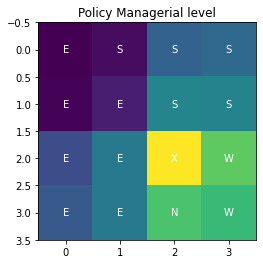

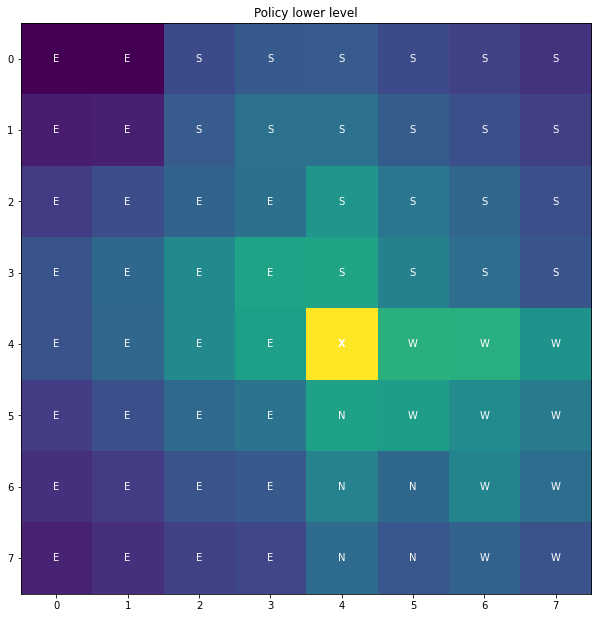

cccc


In [35]:
print_policy(nn, env1, 0, 0)

array([[0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,

Init
Parameter containing:
tensor([[0.8365, 2.0780, 3.5388]], requires_grad=True) Parameter containing:
tensor([0.])
[0.8365010023117065, 2.0779988765716553, 3.5387604236602783]
Ratio M/L: 1.7029655133878758
[['S' 'S' 'S' 'W']
 ['E' 'Search' 'W' 'W']
 ['N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'W']]
[[list([(0, -7.942709922790527), (1, -2.9876341819763184), (2, -3.2137835025787354), (3, -7.891453742980957)])
  list([(0, -5.515345573425293), (1, -0.008316446095705032), (2, -7.691028594970703), (3, -6.253037929534912)])
  list([(0, -8.858011245727539), (1, -4.421713829040527), (2, -11.429450988769531), (3, -5.767159938812256)])
  list([(0, -13.532307624816895), (1, -17.426042556762695), (2, -20.730998992919922), (3, -8.424760818481445)])]
 [list([(0, -5.9156389236450195), (1, -5.904721736907959), (2, -0.3108557462692261), (3, -5.766600131988525)])
  list([(4, -0.04550276696681976)])
  list([(0, -6.9996795654296875), (1, -17.22028350830078), (2, -15.576603889465332), (3, -1.2712390422821045)])
  lis

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['S' 'W' 'W' 'W' 'S' 'W' 'W' 'W' 'S' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['S' 'MW' 'N' 'MN' 'S' 'MS' 'N' 'MN' 'S' 'MS' 'N' 'MN' 'W' 'MN' 'N' 'MN']
 ['S' 'W' 'MS' 'MS' 'S' 'S' 'MS' 'MS' 'S' 'S' 'MS' 'MS' 'W' 'N' 'MN' 'MN']
 ['E' 'MS' 'MS' 'MS' 'S' 'MS' 'MS' 'MS' 'S' 'MS' 'MS' 'MS' 'W' 'MW' 'MN'
  'MS']
 ['E' 'E' 'E' 'E' 'X' 'MW' 'MW' 'MW' 'W' 'W' 'W' 'W' 'MW' 'MW' 'MW' 'MW']
 ['N' 'ME' 'E' 'ME' 'MN' 'MW' 'MW' 'MW' 'W' 'MN' 'N' 'MW' 'MW' 'MW' 'MW'
  'MN']
 ['N' 'W' 'ME' 'ME' 'MN' 'MN' 'MN' 'MN' 'W' 'W' 'MW' 'MW' 'MW' 'MW' 'MW'
  'MN']
 ['N' 'MW' 'ME' 'ME' 'MN' 'MN' 'MN' 'ME' 'W' 'MW' 'MW' 'MW' 'MW' 'MW'
  'MW' 'MS']
 ['N' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'MN' 'MN' 'MN' 'MN' 'MW' 'MW' 'MW' 'MW']
 ['N' 'MW' 'N' 'MN' 'N' 'MN' 'N' 'MN' 'MN' 'MN' 'MN' 'MN' 'MW' 'MW' 'MW'
  'MN']
 ['N' 'W' 'MW' 'MN' 'N' 'W' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MW' 'MW' 'MW'
  'MN']
 ['N' 'MW' 'MW' 'ME' 'N' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MW' 'MW'
  'MW' 'MS']
 ['N' 'W' 'W' 'N' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MW' 

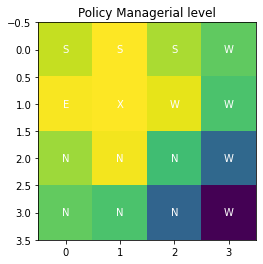

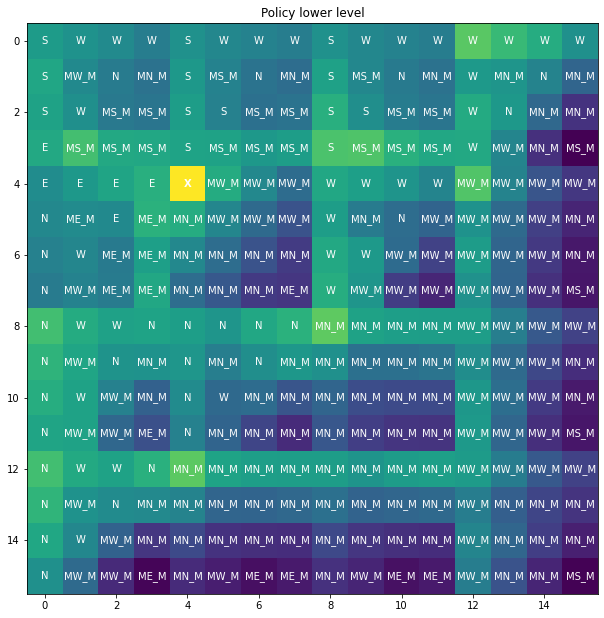

cccc
State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,c

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] -8 True -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 6
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 4 [0, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 1 [0, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_

[1, 8] 1 [2, 8] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] -6 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] -7 False -7 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 12
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 4 [0, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] -1 False -1 2 [[0, 0], [0

[0, 3] 3 [0, 2] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 3 [0, 1] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 3 [0, 0] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] -6 False -6 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -7 False -7 2 [[0, 0], [1, 0]] [[0, 0

[2, 9] 1 [3, 9] [0, -8, -4] -5 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [4, 9] [0, -2, -1] -6 False -3 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 26
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 4 [1, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 1 [1, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 0 [0, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [

State, 33
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 4 [2, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 1 [2, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 3 [2, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 2 [3, 1] [0, -8, -4] -6 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curre

State, 44
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 4 [2, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 3 [2, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 3 [2, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 45
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 13] 4 [2, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 13] 3 [2, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,cur

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 57
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 4 [3, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [3, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [4, 9] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 58
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 4 [3, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -4 True -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 70
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 4 [4, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 4 [4, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 3 [4, 5] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -8 True -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 71
state,action,new_state,reward,done,ste

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] -8 True -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 81
state,action,new_state,reward,done,step,current_level,cur

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 10] 3 [5, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 10] 0 [4, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] -7 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 91
state,action,new_state,reward,done,step,current_level,c

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 2 [6, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 2 [6, 3] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 2 [6, 4] [0, 0, -4] -8 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 99
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 4 [6, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 2 [6, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 3 [6, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 3 [6, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 109
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 4 [6, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_leve

[7, 5] 0 [6, 5] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 5] 0 [5, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 3 [5, 4] [0, 0, -4] -12 False -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 4] 0 [4, 4] [0, 0, -4] -16 True -4 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 118
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 1 [[0

[8, 1] 4 [8, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 0 [8, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 130
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 4 [8, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 0 [8, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0

[8, 15] 4 [8, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 13] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
State, 144
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 4 [9, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [9, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 0 [7, 9] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 154
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 4 [9, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 155
state,action,new_state,reward,done,step

[10, 4] 4 [10, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [10, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] -6 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 165
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 4 [10, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0,

[10, 15] 3 [10, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 0 [9, 15] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 15] 0 [8, 15] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
State, 176
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 4 [11, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] -1 False -1 2 [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 0 [10, 8] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 0 [9, 8] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
State, 185
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 4 [11, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 0 [11, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 0 [10, 9] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_l

[12, 4] 0 [12, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 0 [11, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 197
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 4 [12, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [12, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [11, 5] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 198
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 4 [12, 6] [0, 0, 0] 0 False 0 0 [

[12, 0] 0 [11, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 210
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 4 [13, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 0 [13, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 0 [12, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 3 [12, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 1] 3 [12, 0] [0, -2, -1] -3 False -3 2 [[0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 0 [12, 13] [0, -8, -4] -4 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 12] [0, -8, -4] -8 False -2 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 222
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 4 [13, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 3 [13, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 0 [12, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,ste

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 0 [12, 7] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
State, 232
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 4 [14, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [14, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [13, 8] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [12, 8] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
State, 233
state,action,new_state,reward,done,st

[15, 2] 0 [15, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 3 [15, 1] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 1] 3 [15, 0] [0, -2, -1] -5 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
State, 243
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 4 [15, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [15, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 2 [15, 4] [0, -8, -24] -24 False -1 2 [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 3 [15, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 1 [15, 15] [0, -8, -4] -4 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 1 [15, 15] [0, -8, -4] -8 False -2 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 2 [3, 1] [0, -8, -4] 0 False -10 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 1] [0, 0, 0] 0 False -11 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,

[0, 9] 1 [0, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 

[0, 11] 3 [0, 10] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 4 [1, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 1 [1, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[2, 4] 1 [3, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 4 [1, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [1, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [2, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 5] 1 [3, 5] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 8] [0, 0, 0] 0 False -7 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

[1, 14] 3 [1, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 0 [0, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 1 [0, 11] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 1] [0, 0, 0] 0 False -7 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 4 [2, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

[2, 10] 1 [2, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 10] 1 [3, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [4, 10] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 10] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] 0 False -5 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 1 [0, 11] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_

[4, 2] 2 [4, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 4 [3, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 1 [3, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 1 [4, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 2] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0

[4, 10] 3 [4, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 12] 4 [3, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 12] 3 [3, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 12] 3 [3, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0],

[4, 15] 3 [4, 15] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 3 [4, 14] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 13] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 12] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 2]] 

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 4 [4, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0]

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 4 [5, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[5, 11] 3 [5, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 10] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 10] 0 [4, 10] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 4 [6, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 2 [6, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 2 [6, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 4 [6, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 3 [6, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 3 [6, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tas

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 4 [7, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 2 [7, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 2 [7, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[7, 9] 3 [7, 8] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 4 [7, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 3 [7, 12] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 

[6, 0] 0 [5, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [8, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 10] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -24 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

[9, 2] 4 [9, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 0 [9, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 0 [8, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 3 [8, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 4 [9, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Ta

[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 4 [9, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 3 [9, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 3 [9, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 13] 3 [9, 12] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 12] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0

[10, 1] 0 [10, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 1] 3 [10, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.

[10, 6] 0 [9, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [8, 6] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 4 [10, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [10, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], 

[7, 9] 3 [7, 9] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 4 [10, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 3 [10, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 3 [10, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[

[7, 9] 3 [7, 9] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -33 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 4 [10, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 3 [10, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 0 [9, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 15] 0 [8, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [

[11, 2] 4 [11, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 0 [11, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 3 [11, 1] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 3 [11, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0,

[11, 7] 0 [11, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 4 [11, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,curre

[7, 11] 3 [7, 11] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 4 [11, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 3 [11, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 1 [12, 15] [0, -8, -24] 0 False -4 2 [[0, 0], [2,

[6, 0] 0 [5, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -16 2 [[0, 0], [1, 1]] [[0, 0], [

[10, 4] 0 [9, 4] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 4 [12, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [12, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [11, 6] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0]

[12, 10] 0 [11, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [11, 10] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [10, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 0 [9, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -16 2 [[0, 0], [1

[12, 11] 0 [12, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [11, 11] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [10, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 0 [9, 11] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False -20 1 [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks

[4, 0] 2 [4, 1] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [13, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0],

[11, 7] 0 [11, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0]

[13, 11] 0 [13, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [12, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [11, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [10, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 0 [9, 11] [0, -8, -4] 0 False -16 2 [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 0 [12, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 3 [12, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 13] [0, 0, 0] 0 False -8 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 3 [12, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_le

[4, 2] 2 [4, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 1] 4 [14, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 1] 0 [14, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 1] 3 [14, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 0] 0 [13, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 4] [0, -2, -21] 0 False -10 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [11, 4] [0, 0, 0] 0 False -10 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [10, 4] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curren

[12, 7] 0 [11, 7] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -21 2 [[0, 0], [1, 1]] [[0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 10] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -33 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curren

[11, 11] 0 [10, 11] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 0 [9, 11] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 14] 4 [14, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.

[9, 0] 0 [8, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 0 [6, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 0 [5, 0] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.

[6, 0] 0 [5, 0] [0, -2, -1] 0 False -15 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -19 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -23 2 [[0, 0], [1, 1]] [[0, 0],

[15, 6] 0 [15, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 6] 2 [15, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 2 [15, 8] [0, -8, -24] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [15, 8] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [14, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [13, 8] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[

[15, 9] 0 [15, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 9] 3 [15, 8] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [14, 8] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [14, 8] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [13, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [12, 8] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -28 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 12] [0, 0, 0] 0 False -28 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 11] [0, -8, -4] 0 False -32 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False -32 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -36 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 13] [0, 0, 0] 0 False -16 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 12] [0, -8, -4] 0 False -20 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 3 [12, 11] [0, -8, -4] 0 False -24 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [12, 11] [0, 0, 0] 0 False -24 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -28 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_l

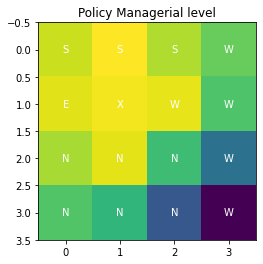

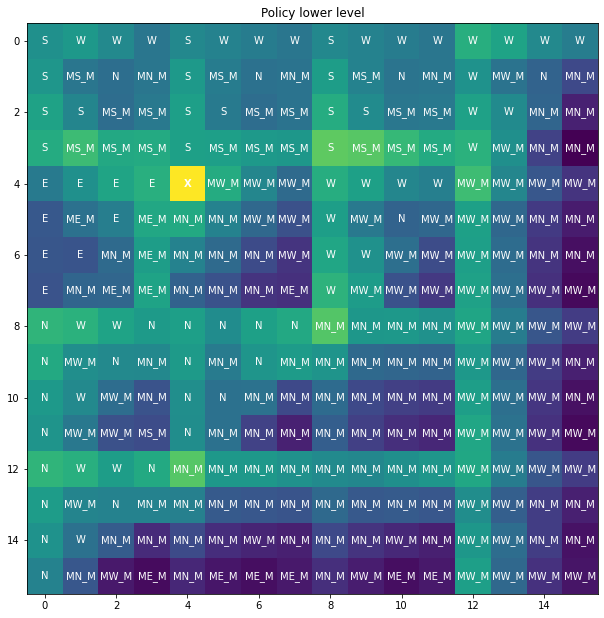

cccc
State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,c

[0, 5] 3 [0, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 1 [1, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] -9 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 7
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 4 [0, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]]

[0, 14] 3 [0, 13] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 15
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 4 [0, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 14] [0, -2, -1] -1 False -1 2 [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 5] 1 [4, 5] [0, 0, -4] -9 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 22
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 6] 4 [1, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 6] 1 [1, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 6] 0 [0, 6] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curren

[0, 8] 1 [1, 8] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] -6 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] -7 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] -8 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 28
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 4 [1, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 3 [1, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 

[2, 5] 1 [3, 5] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 5] 1 [4, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 38
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 4 [2, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 1 [2, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 1 [3, 6] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 6] 1 [4, 6] [0, 0, -4] -8 False -2 2 [[0, 0], [1, 1]] [[

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 1 [4, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 49
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 4 [3, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [3, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 50
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 4 [3, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_l

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 3 [3, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 0 [2, 15] [0, -8, -4] -4 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 0 [1, 15] [0, -8, -4] -8 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
State, 64
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 4 [4, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,cur

[4, 11] 3 [4, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] -7 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 76
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 4 [4, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1

[4, 5] 3 [4, 4] [0, 0, -4] -12 True -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 87
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 7] 4 [5, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 7] 4 [5, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 7] 3 [5, 6] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 6] 3 [5, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 0 [4, 5] [0, 0, -4] -12 False -3 2 [[0,

[6, 2] 0 [5, 2] [0, -2, -1] -6 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
State, 97
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 4 [6, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 2] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 0 [5, 2] [0, -2, -1] -5 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
State, 98
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 4 [6, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 3 [6, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 3 [6, 10] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] -5 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
State, 108
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 4 [6, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 3 [6, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level

[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 0 [6, 6] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 6] 0 [5, 6] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 6] 3 [5, 5] [0, 0, -4] -12 False -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 0 [4, 5] [0, 0, -4] -16 False -4 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -20 True -5 2 [[0, 0], [

[8, 2] 4 [8, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 0 [8, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 3 [8, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 131
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 4 [8, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]]

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [9, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 145
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 1] 4 [9, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 1] 0 [9, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_

[8, 10] 0 [7, 10] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 155
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 4 [9, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 156
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 4 [9, 12] [0, 0, 0] 0 False 0

[9, 4] 0 [8, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] -6 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 165
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 4 [10, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 0 [10, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 0 [9, 5] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 5] 0 [8, 5] [0, -2, -1] -5 False -2 2 [[0, 0], [1,

[9, 15] 0 [8, 15] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
State, 176
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 4 [11, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] -3 False -3 2 [[0, 0]

[11, 9] 0 [10, 9] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 9] 0 [9, 9] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
State, 186
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 4 [11, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [11, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [10, 10] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 0 [9, 10] [0, -8, -4] -8 False -2 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [12, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [11, 6] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 199
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 4 [12, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 0 [12, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 0 [11, 7] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 200
state,action,new_state,reward,done,step,c

[12, 1] 3 [12, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] -4 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 211
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [13, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [12, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] -5 False -2 2 [[0,

[13, 14] 3 [13, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 0 [12, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 3 [12, 13] [0, -8, -4] -8 False -2 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 223
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 4 [13, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 3 [13, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 0 [12, 15] [0, -8, -4] -4 False -

[14, 8] 4 [14, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [14, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [13, 8] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [12, 8] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
State, 233
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 4 [14, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [14, 9] [0, 0, 0] 0 False 0 1 [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 0 [15, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 3 [15, 1] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 1] 0 [14, 1] [0, -2, -1] -5 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
State, 243
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 4 [15, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [15, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_leve

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 3 [15, 12] [0, -8, -4] -8 False -2 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 255
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 4 [15, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 3 [15, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 3 [15, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 14] 3 [15, 13] [0, -8, -4] -8 False -2 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,ste

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 1 [4, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 0] [0, 0, 0] 0 False -7 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 4 [0, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 1 [0, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 

[0, 11] 1 [0, 11] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 4 [1, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,cu

[2, 4] 1 [3, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 4 [1, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [1, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [2, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 5] 1 [3, 5] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1

[1, 8] 1 [2, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 8] [0, 0, 0] 0 False -7 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 11] 4 [1, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 3 [1, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 0 [0, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_T

[4, 1] 2 [4, 2] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 4 [2, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 1 [2, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 1 [3, 2] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 

[2, 10] 1 [3, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [4, 10] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 10] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0]

[0, 10] 3 [0, 9] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0],

[3, 3] 4 [3, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [3, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 3] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 4 [3, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.

[4, 11] 3 [4, 11] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 13] 4 [3, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0

[0, 10] 3 [0, 9] [0, -2, -1] 0 False -15 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -18 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -19 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -20 2 [[0, 0], [1, 2]] [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Task

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 4 [5, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[4, 10] 3 [4, 9] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 4 [5, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 3 [5, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 0 [4, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 

[5, 2] 2 [5, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 4 [6, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 2 [6, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 2 [6, 4] [0, 0, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 4 [6, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 14] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 12] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 12] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,curren

[7, 3] 4 [7, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 2 [7, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 2 [7, 4] [0, 0, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 4] 4 [7, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 4 [7, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.

[7, 12] 3 [7, 12] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 0 [8, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 3 [8, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current

[7, 10] 3 [7, 9] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 8] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 4 [8, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [8, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2

[7, 9] 3 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 4 [8, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 3 [8, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 3 [8, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 1] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

[7, 8] 3 [7, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 4 [9, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 10] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 12] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,curren

[8, 0] 0 [7, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 1] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 0 [6, 1] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 1] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 2] [0, -8, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 

[10, 6] 0 [10, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 0 [9, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [8, 6] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 4 [10, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [10, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 4 [10, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 3 [10, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 4 [10, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 3 [10, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 15] 0 [9, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 15] 0 [8, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curre

[5, 3] 2 [5, 4] [0, 0, -4] 0 False -23 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 4 [11, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 0 [11, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 3 [11, 1] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 3 [11, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0

[11, 4] 4 [11, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [11, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [10, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0],

[11, 10] 0 [10, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 0 [9, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 10] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]

[8, 11] 0 [7, 11] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -24 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -33 2 [[0, 0], [1, 1]] [[0

[7, 1] 0 [6, 1] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 1] [0, 0, 0] 0 False -10 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 2] [0, -8, -4] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 0 [5, 2] [0, -2, -1] 0 False -15 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 2] [0, 0, 0] 0 False -15 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] 0 False -19 2 [[0, 0], [1, 1]] [[0, 0], [

[12, 3] 0 [11, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, -2, -21] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [12, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 0]] [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [9, 6] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [8, 6] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 4 [12, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 0 [12, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,c

[7, 10] 3 [7, 9] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 8] [0, 0, 0] 0 False -25 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 4 [12, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [12, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0,

[7, 11] 3 [7, 11] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 4 [12, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 3 [12, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 3 [12, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 2] [0, -8, -4] 0 False -15 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 0 [5, 2] [0, -2, -1] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 2] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 0 [11, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, -2, -21] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [12, 3] [0, 0, 0] 0 False -6 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 0 [13, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 0 [12, 6] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [11, 6] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [11, 6] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [10, 6] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

[13, 10] 0 [12, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 10] 0 [11, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [11, 10] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 0 [10, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 0 [9, 10] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False -16 1 [[0, 0], 

[13, 12] 3 [13, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [13, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 11] 0 [12, 11] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 11] 0 [11, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [11, 11] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 0 [10, 11] [0, -8, -4] 0 False -20 2 [[0, 

[12, 0] 0 [11, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [11, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0]

[7, 0] 2 [7, 0] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 1] [0, -8, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 0 [6, 1] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 1] [0, 0, 0] 0 False -14 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 2 [6, 2] [0, -8, -4] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 0 [5, 2] [0, -2, -1] 0 False -19 2 [[0, 0], [1, 1]] [[0, 0], [1

[14, 5] 4 [14, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 0 [14, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 0 [13, 5] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 5] 0 [12, 5] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [12, 5] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [11, 5] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0

[9, 8] 0 [8, 8] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 0 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 8] [0, 0, 0] 0 False -25 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 4 [14, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [14, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], 

[7, 11] 3 [7, 11] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 12] 4 [14, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 12] 3 [14, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 12] 3 [14, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [3, 

[10, 11] 0 [9, 11] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 15] 4 [14, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 15] 3 [14, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 15] 0 [13, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [3

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 0 [7, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 0] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 2 [7, 1] [0, -8, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,cu

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 4 [15, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 0 [15, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 0 [14, 4] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tas

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [15, 8] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 0 [14, 8] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [13, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [13, 8] [0, 0, 0] 0 False -12 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [12, 8] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False -12 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -16 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 12] [0, 0, 0] 0 False -16 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 11] [0, -8, -4] 0 False -20 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False -20 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_le

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False -28 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -32 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 12] [0, 0, 0] 0 False -32 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 11] [0, -8, -4] 0 False -36 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 4 [15, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_

[15, 11] 0 [15, 11] [0, 0, 0] 0 False -16 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -20 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 12] [0, 0, 0] 0 False -20 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 3 [15, 11] [0, -8, -4] 0 False -24 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 0 [15, 11] [0, 0, 0] 0 False -24 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 2 [15, 12] [0, -8, -24] 0 False -28 2 [[0

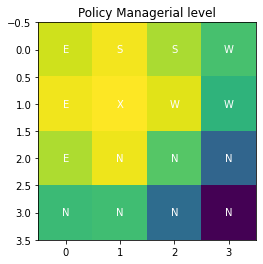

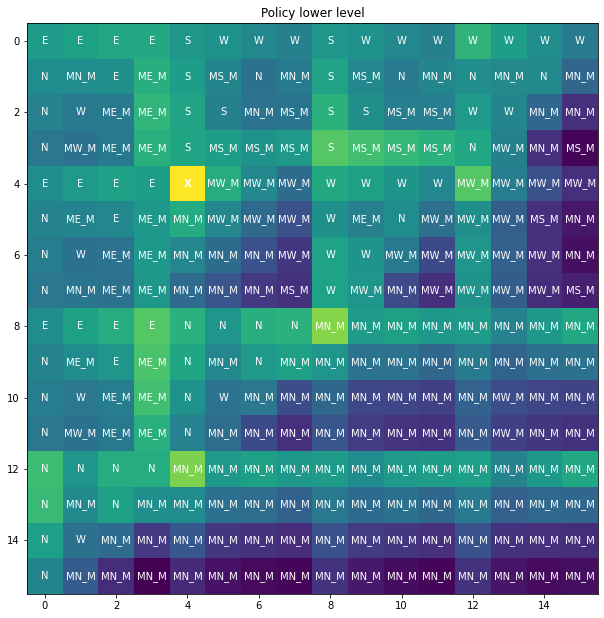

cccc
State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 2 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 2 [0, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 2 [0, 2] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 2 [0, 3] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,c

[0, 4] 1 [1, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] -6 False -6 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] -10 True -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 8
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 4 [0, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [0, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 14] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] -4 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 16
state,action,new_state,reward,done,step,current_l

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 7] 1 [1, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 7] 0 [0, 7] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 3 [0, 6] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,c

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 30
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 4 [1, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 3 [1, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 14] 0 [0, 14] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_l

[2, 5] 1 [3, 5] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 5] 1 [4, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 38
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 4 [2, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 1 [2, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 0 [1, 6] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 6] 0 [0, 6] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [

[0, 12] 3 [0, 11] [0, -2, -1] -5 False -5 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 47
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 4 [2, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 3 [2, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 0 [1, 15] [0, -8, -4] -4 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 0 [0, 15] [0, -2, -1] -5 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
State, 48
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 4 [3, 0] [0, 0, 0] 0 False 0 0 [

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [3, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 1 [4, 9] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 58
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 4 [3, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [3, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [4, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 59
state,action,new_state,reward,done,step,current

[4, 6] 3 [4, 5] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -8 True -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 71
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 4 [4, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 4 [4, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 3 [4, 6] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 3 [4, 5] [0, 0, -4] -8 False -2 2 [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] -5 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] -9 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 82
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 4 [5, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,curren

[4, 8] 3 [4, 7] [0, 0, -4] -7 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 91
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 4 [5, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 10] 0 [4, 10] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] -3 False -3 2 [[0, 0], 

[6, 3] 2 [6, 4] [0, 0, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 100
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 4 [6, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 4 [6, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 0 [5, 4] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 4] 0 [4, 4] [0, 0, -4] -8 True -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 101
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 5] 4 [6, 5] [0, 0, 0] 0 False 0 0 [

[6, 14] 3 [6, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 3 [6, 13] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 12] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
State, 111
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 15] 4 [6, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 15] 3 [6, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 15] 0 [5, 15] [0, -8, -4] -4 False -1 2 [[0, 0],

[7, 6] 0 [6, 6] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 6] 0 [5, 6] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 6] 3 [5, 5] [0, 0, -4] -12 False -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 3 [5, 4] [0, 0, -4] -16 False -4 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 4] 0 [4, 4] [0, 0, -4] -20 True -5 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 119
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 7] 4 [7, 7] [0, 0, 0] 0 False 0 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 130
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 4 [8, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curr

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 2 [9, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] -4 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,c

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [9, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 0 [8, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 0 [7, 11] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 156
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 4 [9, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 0 [9, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_leve

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] -6 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 165
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 4 [10, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 0 [10, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_leve

[10, 15] 0 [9, 15] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 15] 0 [8, 15] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
State, 176
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 4 [11, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 2 [11, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] -2 False -2 2 [[0,

[11, 7] 4 [11, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
State, 184
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 4 [11, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 0 [11, 8] [0, 0, 0] 0 False 0 1 [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 196
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 4 [12, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 0 [12, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 0 [11, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 197
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 4 [12, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,st

[13, 2] 0 [12, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 0 [11, 2] [0, -8, -4] -5 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 211
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [13, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 0 [12, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] -5 False -2 2 [[0,

[13, 14] 0 [13, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 0 [12, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 14] 0 [11, 14] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
State, 223
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 4 [13, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 0 [13, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 0 [12, 15] [0, -8, -4] -4 False -

[14, 8] 0 [13, 8] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 0 [12, 8] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
State, 233
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 4 [14, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [14, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [13, 9] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 9] 0 [12, 9] [0, -8, -4] -8 False -2 2 [[0,

[15, 2] 0 [14, 2] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 2] 0 [13, 2] [0, -2, -1] -5 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
State, 243
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 4 [15, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [15, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [14, 3] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 0 [13, 3] [0, -8, -4] -8 False -2 2 [[0,

[15, 14] 0 [15, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 14] 0 [14, 14] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 14] 0 [13, 14] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 255
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 4 [15, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 0 [15, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 0 [14, 15] [0, -8, -4] -4 False -

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 4 [0, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [0, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

[0, 10] 1 [0, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.

[3, 8] 1 [4, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 8] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 4 [0, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [

[3, 4] 1 [4, 4] [0, 0, -4] 0 True -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 4 [1, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 2 [1, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 0 [0, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 2 [0, 2] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 2 [0, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 

[1, 7] 1 [1, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 7] 0 [0, 7] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 3 [0, 6] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 1 [1, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 4 [1, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 3 [1, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 0 [0, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 1 [0, 11] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 2]] [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 3 [1, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 0 [0, 15] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 3 [0, 14] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_T

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [2, 4] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 4 [2, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 2 [2, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [4, 10] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 10] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks

[2, 0] 0 [1, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 0 [0, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 2 [0, 1] [0, -2, -1] 0 False -5 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 2 [0, 2] [0, -2, -1] 0 False -6 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 2 [0, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 2 [0, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [0, 1]] [[0, 0], [0.

[4, 10] 3 [4, 10] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 4 [3, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 1 [3, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 1 [3, 8] [0, -2, -1] 0 False -15 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

[4, 9] 3 [4, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 4 [4, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [

[4, 12] 3 [4, 11] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -13 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -15 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -20 2 [[0, 0], [1, 1]] [[

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 12] 4 [5, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 12] 3 [5, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 12] 3 [5, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 4 [6, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 2 [6, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 0 [5, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0,

[6, 10] 3 [6, 9] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 9] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 4 [6, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [

[4, 2] 2 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 4 [7, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 2 [7, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 0 [6, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 3 [6, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 10] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 4 [7, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_T

[7, 15] 3 [7, 15] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 1 [8, 15] [0, -8, -24] 0 False -36 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 4 [8, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 4 [8, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [8, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,cur

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 0 [8, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 0 [7, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 14] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 3 [7, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 2] 2 [9, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 2 [9, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [9, 4] [0, 0, 0] 0 False -6 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [9, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 10] 0 [8, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 0 [7, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 10] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 0 [6, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -30 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 4 [9, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 0 [9, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 0 [8, 14] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 0 [7, 14] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Ta

[10, 1] 4 [10, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 1] 2 [10, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 1] 3 [10, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0]

[8, 7] 0 [7, 7] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 4 [10, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 0 [10, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 0 [9, 8] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 0 [8, 8] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 0 [8, 8] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.

[9, 12] 0 [8, 12] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 0 [8, 12] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 0 [7, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 12] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 11] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[

[10, 15] 0 [9, 15] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 15] 0 [8, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [8, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [7, 15] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 3 [7, 15] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 1 [8, 15] [0, -8, -24] 0 False -16 2 [[0, 0], [1, 2]]

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [11, 4] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [10, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Task

[11, 9] 0 [10, 9] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 9] 0 [9, 9] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 9] 0 [9, 9] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 9] 0 [8, 9] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 0 [7, 9] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [

[7, 10] 0 [6, 10] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 10] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -30 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -34 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 13] 4 [11, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] 

[8, 15] 0 [8, 15] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [7, 15] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 3 [7, 15] [0, 0, 0] 0 False -24 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 1 [8, 15] [0, -8, -24] 0 False -28 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [8, 15] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [7, 15] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 3]]

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [11, 4] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [10, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

[11, 8] 0 [11, 8] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 0 [10, 8] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 0 [9, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 0 [9, 8] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 0 [8, 8] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 0 [7, 8] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 2]] [[0, 0]

[7, 11] 3 [7, 11] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 0 [6, 10] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 10] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -30 2 [[0, 0], [1, 1]] [

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 0 [8, 14] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 0 [7, 14] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 14] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 3 [7, 13] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 13] 3 [7, 12] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,cur

[11, 0] 0 [10, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0

[10, 5] 3 [10, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 4 [13, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 0 [13, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0,

[7, 9] 3 [7, 8] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 4 [13, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 0 [13, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 0 [12, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 10] 0 [11, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 0 [6, 10] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 4 [13, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 0 [13, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 0 [12, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 0 [11, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level

[8, 15] 0 [8, 15] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 0 [7, 15] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 3 [7, 15] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 1 [8, 15] [0, -8, -24] 0 False -36 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 0] 4 [14, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 0] 0 [14, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [

[11, 4] 0 [10, 4] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 4 [14, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 0 [14, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0,

[11, 6] 0 [11, 6] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [10, 6] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 0 [9, 6] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [9, 6] [0, 0, 0] 0 False -17 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [8, 6] [0, -2, -1] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -22 2 [[0, 0], [1, 1]] [[0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 10] 4 [14, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 10] 0 [14, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 10] 0 [13, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 0 [12, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 10] 0 [12, 10] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,

[7, 11] 3 [7, 11] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 13] 4 [14, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 13] 0 [14, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 13] 0 [13, 13] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 0 [12, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [2

[8, 15] 0 [7, 15] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 4 [15, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [15, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 0] 0 [14, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 0] 0 [13, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 0] 0 [12, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [

[9, 4] 0 [8, 4] [0, -2, -1] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -22 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 4 [15, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [15, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 0 [14, 3] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 0 [13, 3] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 0]] [[0, 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 0 [11, 6] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [11, 6] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [10, 6] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 0 [9, 6] [0, -2, -1] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 0 [9, 6] [0, 0, 0] 0 False -21 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_

[9, 9] 0 [8, 9] [0, -8, -4] 0 False -28 2 [[0, 0], [1, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 0 [7, 9] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -33 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 4 [15, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 0 [15, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 0 [7, 12] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 12] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 3 [7, 11] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 4 [15, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 0 [15, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,cur

tensor([0.1101], requires_grad=True)
[0.17837366461753845, 1.0020321607589722, -0.9805511236190796]
Ratio M/L: -0.9785625272509995
[['S' 'S' 'S' 'W']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'W' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -5.9765777587890625), (1, -2.7909436225891113), (2, -3.7370073795318604), (3, -6.6647629737854)])
  list([(0, -1.2878239154815674), (1, 0.9592219591140747), (2, -5.482100963592529), (3, -5.375243663787842)])
  list([(0, -3.194571018218994), (1, -1.6513477563858032), (2, -7.792124271392822), (3, -3.740499973297119)])
  list([(0, -10.040190696716309), (1, -14.458192825317383), (2, -14.129538536071777), (3, -7.650778770446777)])]
 [list([(0, -5.659545421600342), (1, -5.768820762634277), (2, 0.8213546872138977), (3, -1.611544132232666)])
  list([(4, 1.0952967405319214)])
  list([(0, -5.554433345794678), (1, -15.912637710571289), (2, -13.175365447998047), (3, 1.3807907104492188)])
  list([(0, -14.946432113647461), (1, -21.652587890625), (2, -17.02815055847168), (3, -6.6

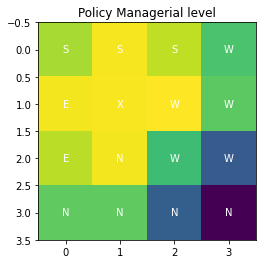

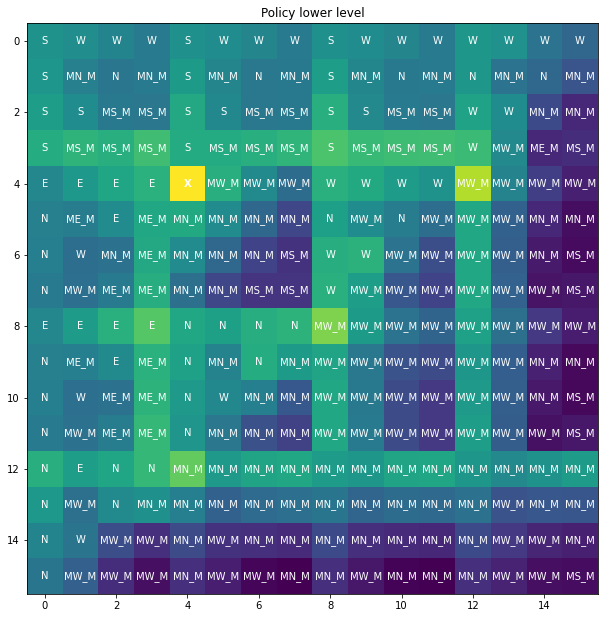

cccc
State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,c

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 1 [0, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 1 [1, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,c

[0, 14] 4 [0, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 15
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 4 [0, 15] [0, 0, 0] 0 False 0 0 [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] -6 True -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 21
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 4 [1, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 1 [1, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current

[1, 10] 1 [1, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 0 [0, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] -5 False -5 2 [[0, 0], [1, 2]] [[0, 

[2, 1] 1 [2, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 1 [3, 1] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] -5 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
State, 34
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 4 [2, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 1 [2, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 2] 1 [3, 2] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 0]] [[0,

[2, 12] 3 [2, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 45
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 13] 4 [2, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 13] 3 [2, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 13] 3 [2, 12] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 12] 3 [2, 11] [0, -8, -4] -5 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
State, 46
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 4 [2, 14] [0, 0, 0] 0 False 0 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [3, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 1 [4, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 59
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 4 [3, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 1 [3, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 1 [4, 11] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 60
state,action,new_state,reward,done,step,cur

State, 71
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 4 [4, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 4 [4, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 3 [4, 6] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 3 [4, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -12 True -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 72
state,action,new_state,reward,done,s

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] -8 True -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
State, 81
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 4 [5, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current

[5, 10] 0 [4, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] -7 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 91
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 4 [5, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 0 [5, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] -5 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] -9 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 99
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 4 [6, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 2 [6, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curren

[6, 12] 3 [6, 11] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 109
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 4 [6, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 3 [6, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 3 [6, 11] [0, -8, -4] -8 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
State, 110
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 4 [6, 14] [0, 0, 0] 0 False 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 4 [7, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 0 [6, 5] [0, 0, -4] -4 False -1 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 5] 0 [5, 5] [0, 0, -4] -8 False -2 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 0 [4, 5] [0, 0, -4] -12 False -3 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, 0, -4] -16 True -4 2 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [5, 5, 5] [1. 1.]
State, 118
state,action,new_state,reward,done,step,c

[8, 1] 2 [8, 2] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 129
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 4 [8, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]]

[8, 13] 4 [8, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
State, 142
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 4 [8, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 14] [0, 0, 0] 0 False 0 1 [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] -5 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 152
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 4 [9, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 3 [9, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_T

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] -5 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] -6 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] -7 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
State, 162
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 2] 4 [10, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 2] 2 [10, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 13] 3 [10, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 13] 3 [10, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 12] 3 [10, 11] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
State, 174
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 14] 4 [10, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 14] 3 [10, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,cu

[10, 5] 3 [10, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] -8 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
State, 182
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 4 [11, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 6] 0 [11, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [

[12, 2] 4 [12, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 0 [12, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 2] 0 [11, 2] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 195
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 4 [12, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [12, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 3] 0 [11, 3] [0, -8, -4] -4 False -1 2 [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 0] 0 [12, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 210
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 4 [13, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 0 [13, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 2] 0 [12, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_

[13, 13] 4 [13, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 0 [13, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 13] 3 [13, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 12] 0 [12, 12] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 222
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 4 [13, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 14] 0 [13, 14] [0, 0, 0] 0 False 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 0 [14, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 0 [13, 7] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 0 [12, 7] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
State, 232
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 4 [14, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 0 [14, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_leve

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] -5 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
State, 242
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 4 [15, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 0 [15, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 2] 3 [15, 1] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 1] 3 [15, 0] [0, -2, -1] -5 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
State, 243
state,action,new_state,reward,done,st

[15, 13] 0 [15, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 3 [15, 12] [0, -8, -4] -4 False -1 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 12] 0 [14, 12] [0, -8, -4] -8 False -2 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
State, 254
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 14] 4 [15, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 14] 0 [15, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 14] 3 [15, 13] [0, -8, -4] -4 False -

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 1 [0, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 3 [0, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 3 [0, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 1] 3 [0, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[2, 8] 1 [3, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 1 [4, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 8] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 4 [0, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 1 [0, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.

[0, 13] 3 [0, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 1 [0, 11] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 

[3, 0] 1 [4, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 

[4, 3] 2 [4, 4] [0, 0, -4] 0 True -15 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 4 [1, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [1, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 1 [2, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 1 [3, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 1 [4, 4] [0, 0, -4] 0 True -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.

[4, 8] 3 [4, 8] [0, 0, 0] 0 False -6 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 4 [1, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 1 [1, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 0 [0, 10] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], 

[0, 11] 1 [0, 11] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 9] 3 [0, 8] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 8] 1 [1, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 1 [2, 8] [0, -2, -1] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 0] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

[3, 8] 1 [4, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 8] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 4 [2, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 1 [2, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 1 [3, 9] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.

[4, 10] 3 [4, 9] [0, -2, -1] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 3 [4, 7] [0, 0, -4] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 4 [2, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 3 [2, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 2]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 0 [1, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 2]] [[0, 

[3, 1] 4 [3, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [3, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 1] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0

[3, 11] 1 [3, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 1 [4, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 10] 3 [4, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 9] 3 [4, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 3 [4, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 13] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 3 [4, 12] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -17 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curre

[4, 8] 3 [4, 7] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 4 [4, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 12] 3 [4, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 11] 3 [4, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0]

[4, 3] 2 [4, 4] [0, 0, -4] 0 True -8 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [5, 1, 1] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 4 [5, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 2 [5, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 2 [5, 3] [0, -8, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 2 [5, 4] [0, 0, -4] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.

[5, 13] 4 [5, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 3 [5, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 3 [5, 12] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 12] 3 [5, 11] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 11] 3 [5, 10] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0,

[6, 0] 0 [5, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -10 2 [[0, 0], [1, 1]] [[0, 0], [1.0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 3 [6, 9] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 9] [0, 0, 0] 0 False -13 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 9] 3 [6, 8] [0, -2, -1] 0 False -14 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 3 [6, 7] [0, 0, -4] 0 False -18 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 4 [6, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tas

[6, 0] 0 [5, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 0 [4, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 2 [4, 1] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 2 [4, 2] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 2] 2 [4, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 2 [4, 4] [0, 0, -4] 0 True -11 2 [[0, 0], [1, 1]] [[0, 0], [1.0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 11] 3 [7, 10] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 3 [7, 9] [0, -8, -4] 0 False -16 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 9] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 9] 3 [7, 8] [0, -2, -1] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 3 [7, 7] [0, 0, -4] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tas

[8, 4] 0 [7, 4] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 4 [8, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [8, 4] [0, 0, 0] 0 False -2 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 9] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [8, 7] [0, 0, 0] 0 False -13 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -17 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,cur

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -8, -4] 0 False -28 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -29 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [8, 7] [0, 0, 0] 0 False -29 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -33 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 4 [9, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 0 [7, 6] [0, 0, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 4 [9, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -5 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 8] 3 [9, 7] [0, -8, -4] 0 False -20 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -20 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -21 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 13] 4 [9, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Task

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -8, -4] 0 False -32 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -33 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 4 [10, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 2 [10, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tas

[10, 5] 0 [10, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -7 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 4 [10, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 11] 3 [10, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 3 [10, 9] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 9] 3 [10, 9] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 9] 3 [10, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 3 [10, 7] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,cur

[8, 14] 3 [8, 13] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 12] [0, 0, 0] 0 False -16 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -8, -4] 0 False -20 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 11] [0, 0, 0] 0 False -20 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 10] [0, -8, -4] 0 False -24 2 [[0, 0], [2, 1]

[9, 0] 0 [8, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [8, 4] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -4 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,c

[8, 7] 0 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 4 [11, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 11] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 11] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 

[11, 15] 1 [12, 15] [0, -8, -24] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [12, 15] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [11, 15] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 3 [11, 15] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 1 [12, 15] [0, -8, -24] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [12, 15] [0, 0, 0] 0 False -12 1 [[0, 0]

[11, 2] 2 [11, 2] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 2 [11, 3] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 2 [11, 4] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [11, 4] [0, 0, 0] 0 False -9 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 0 [10, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -11 2 [[0, 0], [1, 1]] [[0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -8 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -12 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -12 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -13 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Task

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 11] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 3 [11, 9] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 9] [0, 0, 0] 0 False -12 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,cu

[11, 14] 3 [11, 13] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 13] 3 [11, 12] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 12] [0, 0, 0] 0 False -12 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 11] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 11] [0, 0, 0] 0 False -16 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -8, -4] 0 False -20 2 [[0,

[13, 1] 0 [13, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 1] 3 [13, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 0] 0 [12, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 2 [11, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 

[13, 5] 4 [13, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 5] 0 [13, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 5] 0 [12, 5] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 0 [11, 5] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 5] 0 [11, 5] [0, 0, 0] 0 False -8 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 5] 0 [10, 5] [0, -2, -1] 0 False -9 2 [[0, 0], [1, 1]] [[0,

[11, 9] 3 [11, 9] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 3 [11, 7] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False -16 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -20 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -24 2 [[0, 0], [1, 1]] 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 3 [11, 9] [0, -8, -4] 0 False -20 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 9] [0, 0, 0] 0 False -20 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -8, -4] 0 False -24 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 3 [11, 7] [0, -8, -4] 0 False -28 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [12, 15] [0, 0, 0] 0 False -12 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [11, 15] [0, -8, -4] 0 False -16 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 3 [11, 15] [0, 0, 0] 0 False -16 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 1 [12, 15] [0, -8, -24] 0 False -20 2 [[0, 0], [2, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 0 [12, 15] [0, 0, 0] 0 False -20 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_le

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 2] 3 [14, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 1] 3 [14, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 0] 0 [13, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 0] 0 [12, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,curren

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 0 [14, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 3 [14, 4] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 4] 0 [13, 4] [0, -8, -4] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 4] 0 [13, 4] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 4] 0 [12, 4] [0, -8, -4] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Ta

[9, 7] 0 [9, 7] [0, 0, 0] 0 False -24 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -25 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 0 [7, 7] [0, 0, -4] 0 False -29 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 4 [14, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [14, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 9] 0 [13, 9] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0],

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [11, 7] [0, 0, 0] 0 False -28 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 0 [10, 7] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 0 [9, 7] [0, -8, -4] 0 False -36 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 12] 4 [14, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 12] 0 [14, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,curr

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -8, -4] 0 False -28 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 3 [11, 9] [0, -8, -4] 0 False -32 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 9] [0, 0, 0] 0 False -32 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -8, -4] 0 False -36 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 15] 4 [14, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_leve

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 0] 0 [12, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 0] 0 [11, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 2 [11, 0] [0, 0, 0] 0 False -5 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 0 [10, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 0 [9, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_T

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 0 [8, 0] [0, -2, -1] 0 False -16 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 2 [8, 1] [0, -2, -1] 0 False -17 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 2 [8, 2] [0, -2, -1] 0 False -18 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 2 [8, 3] [0, -2, -1] 0 False -19 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 2 [8, 4] [0, -2, -1] 0 False -20 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tas

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 0 [9, 4] [0, -2, -1] 0 False -23 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 0 [8, 4] [0, -2, -1] 0 False -24 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 0 [7, 4] [0, 0, -4] 0 False -28 2 [[0, 0], [1, 1]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 4 [15, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 0 [15, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tas

[10, 7] 0 [9, 7] [0, -8, -4] 0 False -32 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [9, 7] [0, 0, 0] 0 False -32 1 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 0 [8, 7] [0, -2, -1] 0 False -33 2 [[0, 0], [1, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 4 [15, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 0 [15, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 0 [14, 10] [0, -8, -4] 0 False -4 2 [[0, 0], [2, 2]] 

[11, 9] 3 [11, 9] [0, 0, 0] 0 False -28 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -8, -4] 0 False -32 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 3 [11, 7] [0, -8, -4] 0 False -36 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 4 [15, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 0 [15, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 3 [15, 12] [0, -8, -4] 0 False -4 2 [[0, 0], [2,

[15, 15] 1 [15, 15] [0, -8, -4] 0 False -32 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 0 [15, 15] [0, 0, 0] 0 False -32 1 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 1 [15, 15] [0, -8, -4] 0 False -36 2 [[0, 0], [2, 3]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
Init 14.91
Nil 15.22
Exact 14.53
Learn 18.11


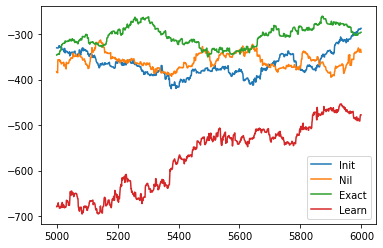

Init 14.91
Nil 15.22
Exact 14.53
Learn 18.11


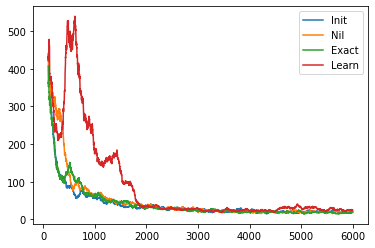

Init -189.69
Nil -186.42
Exact -203.55
Learn -220.95


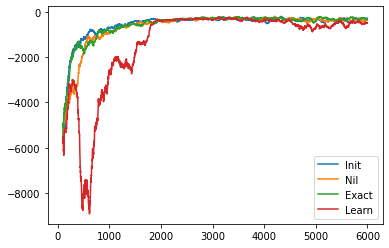

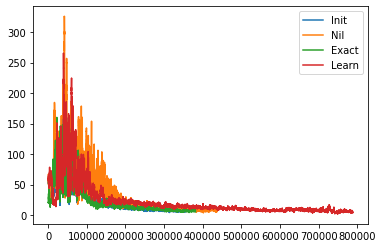

In [61]:
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    nn=r_dict_4[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print("=====================")
    j1v,j2v=print_policy(nn, env2, 0, 0)
    
    rewards_v,rewards_h,man_true_q_avg,man_true_q_max,man_true_q_min=get_true_q(env,nn)
    qs[x1]={'v1':j1v,'v2':j2v,'vt1':rewards_v,'vth':rewards_h,'vt_avg':man_true_q_avg,'vt_max':man_true_q_max,'vt_min':man_true_q_min}
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['rewards']).rolling(300).mean().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    print(labelp,pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    pd.Series(r_dict_4[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

In [48]:
nn.search_lims


[100000, 6.0]

In [62]:
rmse={}
for i,l in enumerate(man_inits):
    print(l)
    diff_2=np.sqrt(np.mean((np.array(qs[i]['v2'])-np.array([x for x in qs[i]['vt1'].values()]))**2))
#     print(diff)
    
    diff_avg=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_avg'].values()]))**2))
#     print(diff)
    diff_max=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_max'].values()]))**2))
    diff_min=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_min'].values()]))**2))

    rmse[l]={'Diff_avg':diff_avg,'Diff_max':diff_max,'Diff_min':diff_min,'Diff_agent':diff_2}

pd.DataFrame(rmse)  

Exact
Init
Learn
Nil


Exact      Init     Learn        Nil
Diff_avg    4.041859  3.913514  4.353739   8.616536
Diff_max    1.818338  1.763827  2.194660   3.537013
Diff_min    6.609923  6.282373  6.701198  15.845524
Diff_agent  1.794527  2.959002  2.423974   7.485124

Learn
Parameter containing:
tensor([[ 0.3799, -0.2122, -0.6338]], requires_grad=True) Parameter containing:
tensor([-0.8933], requires_grad=True)
[-0.5133998394012451, -1.1055243015289307, -1.5271599292755127]
Ratio M/L: 1.3813897416487937
[['E' 'S' 'W' 'W']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'N' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -9.450427055358887), (1, -6.477349281311035), (2, -4.731142997741699), (3, -11.199651718139648)])
  list([(0, -6.045315742492676), (1, -0.8388003706932068), (2, -6.5351338386535645), (3, -4.061154365539551)])
  list([(0, -7.655831813812256), (1, -5.3391618728637695), (2, -10.548544883728027), (3, -3.679574728012085)])
  list([(0, -11.868111610412598), (1, -9.707104682922363), (2, -16.352535247802734), (3, -7.375236988067627)])]
 [list([(0, -5.921713352203369), (1, -10.028693199157715), (2, -0.7139204144477844), (3, -9.495128631591797)])
  list([(4, 0.029443996027112007)])
  list([(0, -4.769591808319092), (1, -10.749300003051758), (2, -9.896766662597656), (3,

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'E' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['ME' 'N' 'ME' 'N' 'MS' 'N' 'MS' 'S' 'MW' 'N' 'MN' 'N' 'MW' 'N' 'MW' 'W']
 ['E' 'ME' 'E' 'E' 'S' 'MS' 'S' 'S' 'W' 'MN' 'N' 'N' 'W' 'MN' 'N' 'W']
 ['MN' 'ME' 'ME' 'E' 'MS' 'MS' 'MS' 'S' 'MW' 'MW' 'MN' 'N' 'MW' 'MW' 'MW'
  'N']
 ['E' 'E' 'E' 'ME' 'X' 'W' 'W' 'W' 'W' 'W' 'W' 'MW' 'W' 'W' 'W' 'W']
 ['MN' 'N' 'ME' 'ME' 'MN' 'N' 'MW' 'N' 'MW' 'W' 'MW' 'MN' 'MN' 'W' 'MW'
  'W']
 ['E' 'ME' 'E' 'ME' 'N' 'MN' 'N' 'W' 'W' 'MW' 'W' 'MW' 'W' 'MN' 'W' 'W']
 ['MN' 'MN' 'ME' 'ME' 'MN' 'MN' 'MN' 'N' 'MW' 'MW' 'MN' 'MN' 'MW' 'MW'
  'MN' 'N']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'MN' 'N' 'N' 'N' 'N' 'W' 'W' 'W' 'W']
 ['ME' 'N' 'ME' 'N' 'MN' 'N' 'MN' 'MN' 'MN' 'N' 'MN' 'N' 'MW' 'W' 'MW'
  'W']
 ['E' 'ME' 'E' 'E' 'N' 'MN' 'N' 'MN' 'N' 'MN' 'N' 'N' 'W' 'MW' 'W' 'W']
 ['MN' 'ME' 'ME' 'E' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'N' 'MW' 'MW'
  'MW' 'N']
 ['E' 'E' 'E' 'ME' 'N' 'N' 'N' 'MN' 'N' 'N' 'N' 'MN' 'N' 'N' 'N' 'N']
 ['MN' 'N' 'MN' 'ME' 'MN' 'N' 'M

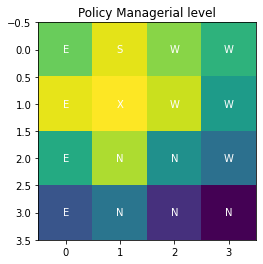

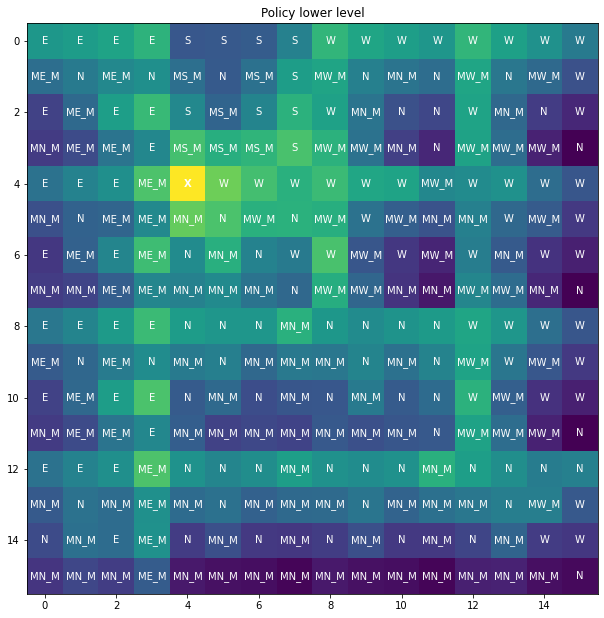

cccc
State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 2 [1, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 1] 2 [1, 2] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,c

[1, 5] 0 [0, 5] [0, -2, -1] -18 False -18 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -19 False -19 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -20 False -20 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -21 False -21 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -22 False -22 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -23 False -23 2 [[0, 0], [1

[0, 5] 1 [1, 5] [0, -2, -1] -63 False -63 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -64 False -64 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -65 False -65 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -66 False -66 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -67 False -67 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -68 False -68 2 [[0, 0], [1

[1, 5] 0 [0, 5] [0, -2, -1] -110 False -110 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -111 False -111 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -112 False -112 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -113 False -113 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -114 False -114 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -115 False -115 2

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -161 False -161 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -162 False -162 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -163 False -163 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -164 False -164 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -165 False -165 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -213 False -213 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -214 False -214 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -215 False -215 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -216 False -216 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -217 False -217 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

[0, 5] 1 [1, 5] [0, -2, -1] -265 False -265 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -266 False -266 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -267 False -267 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -268 False -268 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -269 False -269 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -270 False -270 2

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -318 False -318 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -319 False -319 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -320 False -320 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -321 False -321 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -322 False -322 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

[0, 5] 1 [1, 5] [0, -2, -1] -369 False -369 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -370 False -370 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -371 False -371 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -372 False -372 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -373 False -373 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -374 False -374 2

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -422 False -422 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -423 False -423 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -424 False -424 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -425 False -425 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -426 False -426 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -468 False -468 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -469 False -469 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -470 False -470 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -471 False -471 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -472 False -472 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -521 False -521 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -522 False -522 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -523 False -523 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 0 [0, 5] [0, -2, -1] -524 False -524 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 1 [1, 5] [0, -2, -1] -525 False -525 2 [[0, 0], [1, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
state,action,new_state,reward,done,step,curre

KeyboardInterrupt: 

In [72]:
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    nn=r_dict_5[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    j1v,j2v=print_policy(nn, env3, 0, 0)
    
    rewards_v,rewards_h,man_true_q_avg,man_true_q_max,man_true_q_min=get_true_q(env1,nn)
    qs[x1]={'v1':j1v,'v2':j2v,'vt1':rewards_v,'vth':rewards_h,'vt_avg':man_true_q_avg,'vt_max':man_true_q_max,'vt_min':man_true_q_min}
    print("=====================")


    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    print(labelp,pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    pd.Series(r_dict_5[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

In [79]:
[x for x in range(env3.n_layers)]

[0, 1]

In [ ]:
rmse={}
for i,l in enumerate(man_inits):
    print(l)
    diff_2=np.sqrt(np.mean((np.array(qs[i]['v2'])-np.array([x for x in qs[i]['vt1'].values()]))**2))
#     print(diff)
    
    diff_avg=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_avg'].values()]))**2))
#     print(diff)
    diff_max=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_max'].values()]))**2))
    diff_min=np.sqrt(np.mean((np.array(qs[i]['v1'])-np.array([x for x in qs[i]['vt_min'].values()]))**2))

    rmse[l]={'Diff_avg':diff_avg,'Diff_max':diff_max,'Diff_min':diff_min,'Diff_agent':diff_2}

pd.DataFrame(rmse)  

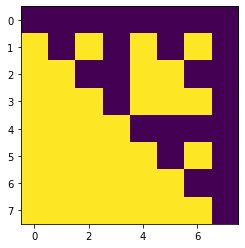

In [12]:
plt.imshow(env2.maze)

In [12]:
env3.goal_init_state

[4, 4]

[3, 0]
[[0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


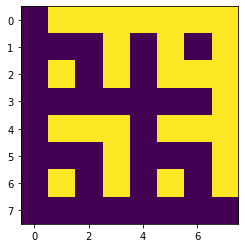

In [20]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 3, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_6={}

# resul6s = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 5000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env4=copy.copy(env)

In [21]:


for man_init in ['Learn','Init','Nil','Exact']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
            print(man_init)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_6[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Exact


  0%|                                                                               | 1/5000 [00:05<7:22:03,  5.31s/it]

epsilon 0.7844266666666667


  0%|▏                                                                             | 13/5000 [00:44<4:24:28,  3.18s/it]

x


  1%|▊                                                                             | 51/5000 [02:11<1:42:49,  1.25s/it]

epsilon 0.7365


  2%|█▌                                                                           | 101/5000 [03:20<2:53:12,  2.12s/it]

epsilon 0.723


  3%|██▎                                                                          | 151/5000 [05:15<1:06:55,  1.21it/s]

epsilon 0.7095


  4%|██▊                                                                          | 185/5000 [06:33<2:54:11,  2.17s/it]

x


  4%|███                                                                          | 201/5000 [07:07<2:20:45,  1.76s/it]

epsilon 0.696


  5%|███▋                                                                         | 243/5000 [08:29<1:32:49,  1.17s/it]

x


  5%|███▉                                                                           | 251/5000 [08:35<54:12,  1.46it/s]

epsilon 0.6825


  6%|████▊                                                                          | 302/5000 [09:19<51:48,  1.51it/s]

epsilon 0.669


  6%|████▊                                                                        | 309/5000 [09:27<1:01:47,  1.27it/s]

x


  7%|█████▏                                                                         | 328/5000 [09:46<48:17,  1.61it/s]

x


  7%|█████▏                                                                       | 333/5000 [09:50<1:11:17,  1.09it/s]

x


  7%|█████▍                                                                       | 351/5000 [10:14<2:31:53,  1.96s/it]

epsilon 0.6555
[92.79666666666667]
min mean 92.79666666666667
last mean 350    94.44
dtype: float64


  8%|██████▎                                                                        | 401/5000 [11:14<43:07,  1.78it/s]

epsilon 0.642
[92.79666666666667, 90.92]
min mean 90.92
last mean 400    93.57
dtype: float64


  9%|██████▊                                                                        | 428/5000 [11:38<44:19,  1.72it/s]

x


  9%|███████▏                                                                       | 451/5000 [11:56<53:07,  1.43it/s]

epsilon 0.6285000000000001
[92.79666666666667, 90.92, 78.42333333333333]
min mean 78.42333333333333
last mean 450    78.953333
dtype: float64


 10%|███████▉                                                                       | 501/5000 [12:25<30:04,  2.49it/s]

epsilon 0.615
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334]
min mean 63.36333333333334
last mean 500    63.363333
dtype: float64


 11%|████████▋                                                                      | 551/5000 [13:03<50:27,  1.47it/s]

epsilon 0.6014999999999999
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62]
min mean 54.62
last mean 550    54.756667
dtype: float64


 12%|█████████▎                                                                   | 601/5000 [13:35<1:12:23,  1.01it/s]

epsilon 0.588
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0]
min mean 52.0
last mean 600    52.336667
dtype: float64


 13%|█████████▉                                                                   | 642/5000 [14:08<1:00:08,  1.21it/s]

x


 13%|██████████▎                                                                    | 651/5000 [14:14<31:17,  2.32it/s]

epsilon 0.5745
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334]
min mean 49.163333333333334
last mean 650    49.163333
dtype: float64


 13%|██████████▍                                                                    | 663/5000 [14:20<34:22,  2.10it/s]

x


 14%|██████████▊                                                                    | 682/5000 [14:33<50:02,  1.44it/s]

x


 14%|███████████                                                                    | 701/5000 [14:41<36:37,  1.96it/s]

epsilon 0.5609999999999999
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667]
min mean 42.71666666666667
last mean 700    42.93
dtype: float64


 14%|███████████▍                                                                   | 723/5000 [14:55<39:10,  1.82it/s]

x


 15%|███████████▊                                                                   | 751/5000 [15:11<51:42,  1.37it/s]

epsilon 0.5475
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68]
min mean 40.68
last mean 750    40.906667
dtype: float64


 16%|████████████▎                                                                | 800/5000 [15:42<1:09:25,  1.01it/s]

epsilon 0.534
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68]
min mean 40.68
last mean 800    41.773333
dtype: float64


 17%|█████████████▍                                                                 | 850/5000 [16:09<36:53,  1.87it/s]

x


 17%|█████████████▍                                                                 | 851/5000 [16:10<45:17,  1.53it/s]

epsilon 0.5205
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667]
min mean 39.61666666666667
last mean 850    40.206667
dtype: float64


 18%|██████████████▏                                                                | 901/5000 [16:36<52:17,  1.31it/s]

epsilon 0.507
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333]
min mean 37.82333333333333
last mean 900    38.79
dtype: float64


 19%|██████████████▋                                                              | 951/5000 [17:11<1:51:08,  1.65s/it]

epsilon 0.4935
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334]
min mean 35.233333333333334
last mean 950    36.39
dtype: float64


 19%|██████████████▊                                                              | 958/5000 [17:18<1:26:45,  1.29s/it]

x


 19%|███████████████▍                                                               | 974/5000 [17:32<53:52,  1.25it/s]

x


 20%|███████████████▌                                                              | 1001/5000 [17:47<49:24,  1.35it/s]

epsilon 0.48
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1000    36.993333
dtype: float64


 21%|████████████████▍                                                             | 1051/5000 [18:29<47:39,  1.38it/s]

epsilon 0.4665
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1050    38.016667
dtype: float64


 21%|████████████████                                                            | 1056/5000 [18:36<1:23:17,  1.27s/it]

x


 22%|████████████████▋                                                           | 1101/5000 [19:18<1:10:00,  1.08s/it]

epsilon 0.45299999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1100    40.61
dtype: float64


 23%|█████████████████▊                                                            | 1142/5000 [19:45<43:18,  1.48it/s]

x


 23%|█████████████████▉                                                            | 1151/5000 [19:47<15:30,  4.13it/s]

epsilon 0.4395
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1150    40.166667
dtype: float64


 23%|█████████████████▉                                                            | 1152/5000 [19:49<38:21,  1.67it/s]

x


 24%|██████████████████▍                                                           | 1182/5000 [20:13<49:35,  1.28it/s]

x


 24%|██████████████████▋                                                           | 1201/5000 [20:23<19:03,  3.32it/s]

epsilon 0.426
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1200    41.36
dtype: float64


 25%|███████████████████▏                                                          | 1233/5000 [20:39<27:27,  2.29it/s]

x


 25%|███████████████████                                                         | 1251/5000 [20:50<1:02:55,  1.01s/it]

epsilon 0.4125
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1250    40.336667
dtype: float64


 26%|███████████████████▋                                                        | 1293/5000 [21:26<1:49:48,  1.78s/it]

x


 26%|████████████████████▎                                                         | 1301/5000 [21:29<34:12,  1.80it/s]

epsilon 0.39899999999999997
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1300    40.976667
dtype: float64


 27%|█████████████████████                                                         | 1351/5000 [21:50<30:39,  1.98it/s]

epsilon 0.3855
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1350    37.346667
dtype: float64


 28%|█████████████████████▊                                                        | 1401/5000 [22:11<28:21,  2.11it/s]

epsilon 0.372
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5]
min mean 31.5
last mean 1400    31.516667
dtype: float64


 29%|██████████████████████▋                                                       | 1451/5000 [22:32<23:22,  2.53it/s]

epsilon 0.3585
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34]
min mean 29.34
last mean 1450    29.763333
dtype: float64


 30%|███████████████████████▍                                                      | 1501/5000 [22:46<14:01,  4.16it/s]

epsilon 0.345
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667]
min mean 25.886666666666667
last mean 1500    25.886667
dtype: float64


 31%|████████████████████████▏                                                     | 1551/5000 [23:04<24:01,  2.39it/s]

epsilon 0.33149999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6]
min mean 24.6
last mean 1550    24.6
dtype: float64


 32%|████████████████████████▊                                                     | 1589/5000 [23:18<12:43,  4.47it/s]

x


 32%|████████████████████████▉                                                     | 1601/5000 [23:21<14:24,  3.93it/s]

epsilon 0.31800000000000006
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334]
min mean 20.733333333333334
last mean 1600    20.74
dtype: float64


 32%|█████████████████████████▏                                                    | 1611/5000 [23:25<26:26,  2.14it/s]

x


 33%|█████████████████████████▊                                                    | 1651/5000 [23:37<23:32,  2.37it/s]

epsilon 0.3045
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666]
min mean 20.016666666666666
last mean 1650    20.066667
dtype: float64


 33%|██████████████████████████                                                    | 1667/5000 [23:41<14:02,  3.96it/s]

x


 34%|██████████████████████████▎                                                   | 1683/5000 [23:46<16:34,  3.33it/s]

x


 34%|██████████████████████████▌                                                   | 1700/5000 [23:51<17:39,  3.12it/s]

epsilon 0.29100000000000004
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668]
min mean 18.986666666666668
last mean 1700    18.986667
dtype: float64


 35%|███████████████████████████▎                                                  | 1752/5000 [24:06<18:29,  2.93it/s]

epsilon 0.27749999999999997
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333]
min mean 17.60333333333333
last mean 1750    17.826667
dtype: float64


 36%|███████████████████████████▊                                                  | 1783/5000 [24:15<15:04,  3.56it/s]

x


 36%|███████████████████████████▉                                                  | 1792/5000 [24:17<10:57,  4.88it/s]

x


 36%|████████████████████████████                                                  | 1801/5000 [24:19<09:23,  5.67it/s]

epsilon 0.264
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332]
min mean 17.173333333333332
last mean 1800    17.486667
dtype: float64


 37%|████████████████████████████▉                                                 | 1851/5000 [24:30<14:24,  3.64it/s]

epsilon 0.25049999999999994
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86]
min mean 15.86
last mean 1850    15.863333
dtype: float64


 38%|█████████████████████████████▋                                                | 1902/5000 [24:42<12:42,  4.06it/s]

epsilon 0.237
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666]
min mean 14.676666666666666
last mean 1900    14.813333
dtype: float64


 39%|██████████████████████████████▍                                               | 1951/5000 [24:53<12:06,  4.20it/s]

epsilon 0.22350000000000003
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334]
min mean 13.843333333333334
last mean 1950    13.856667
dtype: float64


 40%|███████████████████████████████▏                                              | 2002/5000 [25:05<11:29,  4.35it/s]

epsilon 0.20999999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2]
min mean 13.2
last mean 2000    13.57
dtype: float64


 41%|████████████████████████████████                                              | 2053/5000 [25:16<08:16,  5.93it/s]

epsilon 0.1965
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667]
min mean 12.766666666666667
last mean 2050    12.776667
dtype: float64


 42%|████████████████████████████████▊                                             | 2101/5000 [25:26<08:22,  5.77it/s]

epsilon 0.18300000000000005
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334]
min mean 12.183333333333334
last mean 2100    12.21
dtype: float64


 43%|█████████████████████████████████▌                                            | 2151/5000 [25:35<10:40,  4.45it/s]

epsilon 0.16949999999999998
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333]
min mean 11.773333333333333
last mean 2150    11.773333
dtype: float64


 44%|██████████████████████████████████▎                                           | 2201/5000 [25:43<07:32,  6.19it/s]

epsilon 0.15599999999999992
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666]
min mean 11.066666666666666
last mean 2200    11.066667
dtype: float64


 45%|███████████████████████████████████                                           | 2251/5000 [25:51<08:15,  5.55it/s]

epsilon 0.14249999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666]
min mean 10.246666666666666
last mean 2250    10.246667
dtype: float64


 46%|███████████████████████████████████▉                                          | 2301/5000 [26:00<09:09,  4.91it/s]

epsilon 0.129
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667]
min mean 9.366666666666667
last mean 2300    9.366667
dtype: float64


 47%|████████████████████████████████████▋                                         | 2351/5000 [26:09<10:09,  4.35it/s]

epsilon 0.11550000000000005
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77]
min mean 8.77
last mean 2350    8.843333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2402/5000 [26:19<07:05,  6.10it/s]

epsilon 0.10199999999999998
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42]
min mean 8.42
last mean 2400    8.433333
dtype: float64


 49%|██████████████████████████████████████▎                                       | 2453/5000 [26:26<06:21,  6.67it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667]
min mean 8.046666666666667
last mean 2450    8.063333
dtype: float64


 50%|███████████████████████████████████████                                       | 2501/5000 [26:35<07:37,  5.47it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334]
min mean 7.843333333333334
last mean 2500    7.98
dtype: float64


 51%|███████████████████████████████████████▊                                      | 2552/5000 [26:44<09:08,  4.47it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335]
min mean 7.8133333333333335
last mean 2550    8.043333
dtype: float64


 52%|████████████████████████████████████████▌                                     | 2601/5000 [26:52<06:33,  6.10it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335]
min mean 7.8133333333333335
last mean 2600    7.913333
dtype: float64


 53%|█████████████████████████████████████████▎                                    | 2651/5000 [27:00<07:38,  5.12it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55]
min mean 7.55
last mean 2650    7.55
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [27:08<05:37,  6.80it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46]
min mean 7.46
last mean 2700    7.623333
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2750/5000 [27:16<06:15,  5.99it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46]
min mean 7.46
last mean 2750    7.636667
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [27:23<05:49,  6.28it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333]
min mean 7.423333333333333
last mean 2800    7.49
dtype: float64


 57%|████████████████████████████████████████████▍                                 | 2851/5000 [27:32<10:02,  3.57it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39]
min mean 7.39
last mean 2850    7.393333
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2901/5000 [27:42<05:09,  6.78it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19]
min mean 7.19
last mean 2900    7.39
dtype: float64


 59%|██████████████████████████████████████████████                                | 2952/5000 [27:49<05:35,  6.11it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19]
min mean 7.19
last mean 2950    7.47
dtype: float64


 60%|██████████████████████████████████████████████▍                               | 2977/5000 [27:53<05:11,  6.49it/s]

x


 60%|██████████████████████████████████████████████▊                               | 3001/5000 [27:57<06:29,  5.14it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3000    7.553333
dtype: float64


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [28:05<04:21,  7.46it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3050    7.633333
dtype: float64


 61%|███████████████████████████████████████████████▋                              | 3060/5000 [28:06<05:22,  6.02it/s]

x


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [28:12<04:30,  7.02it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3100    7.626667
dtype: float64


 63%|█████████████████████████████████████████████████▏                            | 3151/5000 [28:19<05:44,  5.37it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3150    7.39
dtype: float64


 64%|█████████████████████████████████████████████████▉                            | 3200/5000 [28:26<04:22,  6.86it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3200    7.21
dtype: float64


 65%|██████████████████████████████████████████████████▋                           | 3252/5000 [28:33<03:13,  9.05it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333]
min mean 6.993333333333333
last mean 3250    6.993333
dtype: float64


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [28:41<04:15,  6.66it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333]
min mean 6.863333333333333
last mean 3300    6.863333
dtype: float64


 67%|████████████████████████████████████████████████████▎                         | 3353/5000 [28:50<06:12,  4.42it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71]
min mean 6.71
last mean 3350    6.956667
dtype: float64


 68%|████████████████████████████████████████████████████▉                         | 3394/5000 [28:56<04:07,  6.49it/s]

x


 68%|█████████████████████████████████████████████████████                         | 3401/5000 [28:57<04:04,  6.54it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665]
min mean 6.6466666666666665
last mean 3400    6.69
dtype: float64


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [29:04<04:04,  6.33it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63]
min mean 6.63
last mean 3450    6.63
dtype: float64


 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [29:12<04:21,  5.72it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333]
min mean 6.573333333333333
last mean 3500    6.636667
dtype: floa

 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [29:20<04:13,  5.72it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667]
min mean 6.516666666666667
last mean 3550    6

 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [29:27<03:22,  6.91it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42]
min mean 6.42
last mean 3600    6.46
dty

 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [29:36<07:03,  3.18it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24]
min mean 6.24
last mean 3650    6.

 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [29:46<03:41,  5.87it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24]
min mean 6.24
last mean 3700

 75%|██████████████████████████████████████████████████████████▌                   | 3752/5000 [29:53<02:41,  7.73it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24]
min mean 6.24
last mea

 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [30:00<03:14,  6.16it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24]
min mean 6.24
la

 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [30:08<02:27,  7.77it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24]
min mean 6

 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [30:16<02:44,  6.66it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 79%|█████████████████████████████████████████████████████████████▋                | 3951/5000 [30:23<02:56,  5.96it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [30:30<02:40,  6.23it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 81%|███████████████████████████████████████████████████████████████▏              | 4051/5000 [30:40<04:18,  3.67it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [30:48<02:22,  6.33it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 83%|████████████████████████████████████████████████████████████████▊             | 4152/5000 [30:56<02:27,  5.75it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [31:04<02:13,  5.97it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [31:12<01:57,  6.36it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [31:19<01:40,  6.93it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [31:27<02:06,  5.13it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [31:35<01:40,  5.93it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [31:43<01:49,  5.02it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [31:50<01:23,  5.96it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [32:00<01:35,  4.69it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 92%|███████████████████████████████████████████████████████████████████████▊      | 4601/5000 [32:09<01:49,  3.64it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 92%|████████████████████████████████████████████████████████████████████████      | 4619/5000 [32:12<01:13,  5.18it/s]

x


 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [32:18<00:56,  6.19it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [32:27<01:02,  4.81it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 95%|██████████████████████████████████████████████████████████████████████████    | 4751/5000 [32:36<00:53,  4.70it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [32:44<00:38,  5.18it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [32:52<00:24,  6.04it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [33:03<00:26,  3.68it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4952/5000 [33:13<00:07,  6.34it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:22<00:00,  2.50it/s]


Learn
Parameter containing:
tensor([[ 0.0233, -0.4108, -0.7310]], requires_grad=True) Parameter containing:
tensor([-0.5546], requires_grad=True)
[-0.5312612056732178, -0.9654222130775452, -1.2855589389801025]
Ratio M/L: 1.3316028174678463
[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -20.93901824951172), (1, -13.185060501098633), (2, -13.043227195739746), (3, -20.025968551635742)])
  list([(0, -24.423751831054688), (1, -13.190817832946777), (2, -14.102980613708496), (3, -14.340689659118652)])
  list([(0, -18.38460922241211), (1, -7.595243453979492), (2, -12.587235450744629), (3, -15.0552339553833)])
  list([(0, -19.133678436279297), (1, -9.160857200622559), (2, -12.585050582885742), (3, -11.211342811584473)])]
 [list([(0, -12.869223594665527), (1, -12.964492797851562), (2, -10.46147632598877), (3, -22.024274826049805)])
  list([(0, -13.567352294921875), (1, -12.124242782592773), (2, -10.376357078552246), (3, -14.865314483642578)])
  list

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



xxx


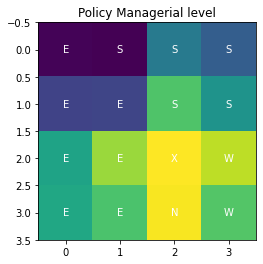

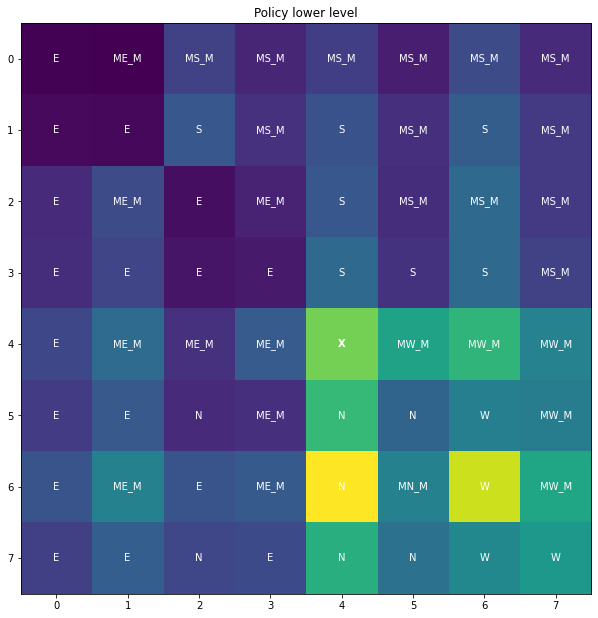

cccc
Init
Parameter containing:
tensor([[0.9295, 1.9911, 4.1347]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9294829368591309, 1.9911009073257446, 4.134709358215332]
Ratio M/L: 2.076594582927832
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -20.916336059570312), (1, -9.848602294921875), (2, -15.222243309020996), (3, -18.810914993286133)])
  list([(0, -22.801265716552734), (1, -10.766159057617188), (2, -16.089061737060547), (3, -16.48604393005371)])
  list([(0, -18.313819885253906), (1, -8.219298362731934), (2, -13.400666236877441), (3, -18.33332061767578)])
  list([(0, -20.763872146606445), (1, -10.601542472839355), (2, -16.046079635620117), (3, -16.349830627441406)])]
 [list([(0, -15.35989761352539), (1, -9.496475219726562), (2, -12.114876747131348), (3, -18.80821418762207)])
  list([(0, -14.005050659179688), (1, -9.29905891418457), (2, -11.7381591796875), (3, -13.487516403198242)])
  list([(0, -6.166957378387451), (1, -4

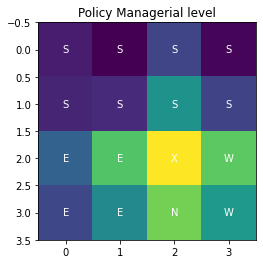

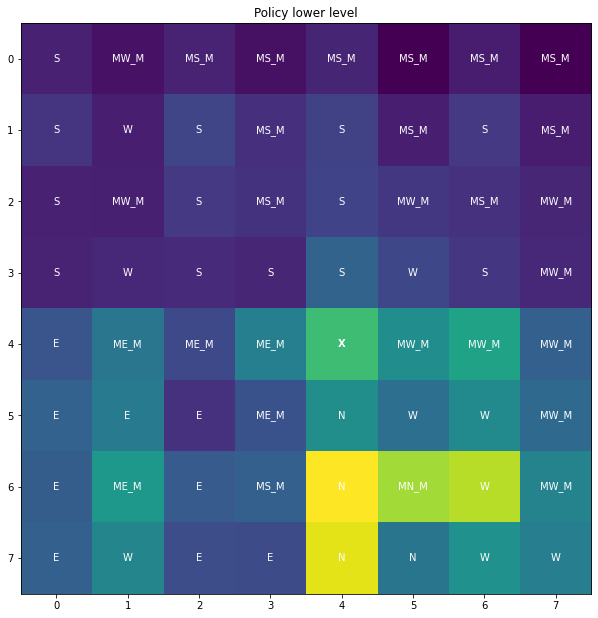

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -21.1901798248291), (1, -10.487678527832031), (2, -15.26687240600586), (3, -20.455202102661133)])
  list([(0, -24.566377639770508), (1, -10.742239952087402), (2, -17.980024337768555), (3, -15.305994033813477)])
  list([(0, -18.617143630981445), (1, -7.447366714477539), (2, -15.059622764587402), (3, -16.423864364624023)])
  list([(0, -20.665878295898438), (1, -8.378759384155273), (2, -17.254533767700195), (3, -11.284643173217773)])]
 [list([(0, -15.424158096313477), (1, -11.770614624023438), (2, -12.711006164550781), (3, -21.90553092956543)])
  list([(0, -18.185569763183594), (1, -10.429009437561035), (2, -14.786270141601562), (3, -13.782581329345703)])
  list([(0, -10.907965660095215), (1, -4.948206424713135), (2, -12.369028091430664), (3, -11.966609954833984)])
  list([(0, -

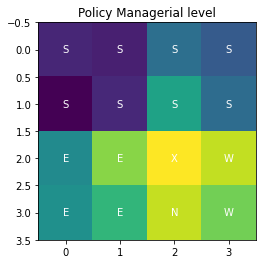

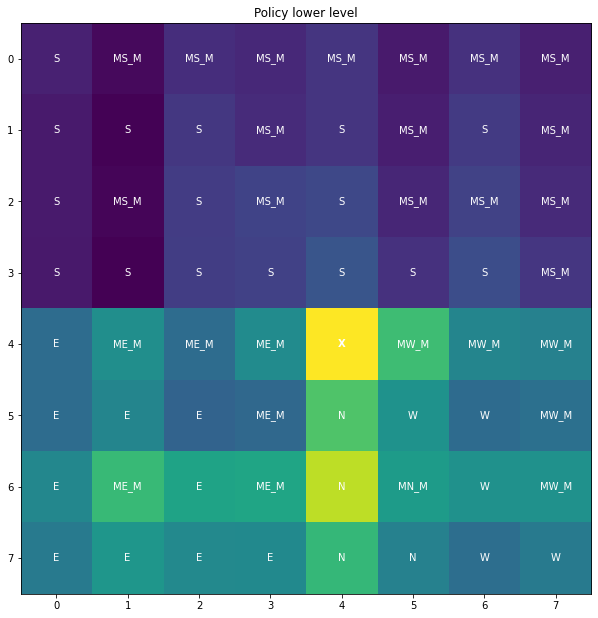

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -19.68153190612793), (1, -10.187191009521484), (2, -14.75798511505127), (3, -20.938840866088867)])
  list([(0, -23.318078994750977), (1, -10.322500228881836), (2, -16.471084594726562), (3, -16.720752716064453)])
  list([(0, -18.26339340209961), (1, -7.978264808654785), (2, -14.294721603393555), (3, -20.562881469726562)])
  list([(0, -19.325000762939453), (1, -9.678900718688965), (2, -15.599279403686523), (3, -18.17959976196289)])]
 [list([(0, -13.283105850219727), (1, -10.532876968383789), (2, -12.697856903076172), (3, -20.392019271850586)])
  list([(0, -14.649474143981934), (1, -9.739357948303223), (2, -13.854247093200684), (3, -13.063739776611328)])
  list([(0, -6.855845928192139), (1, -5.022467613220215), (2, -13.573407173156738), (3, -14.340620040893555)])
  list([(0, -

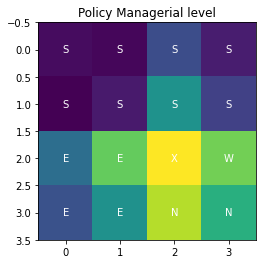

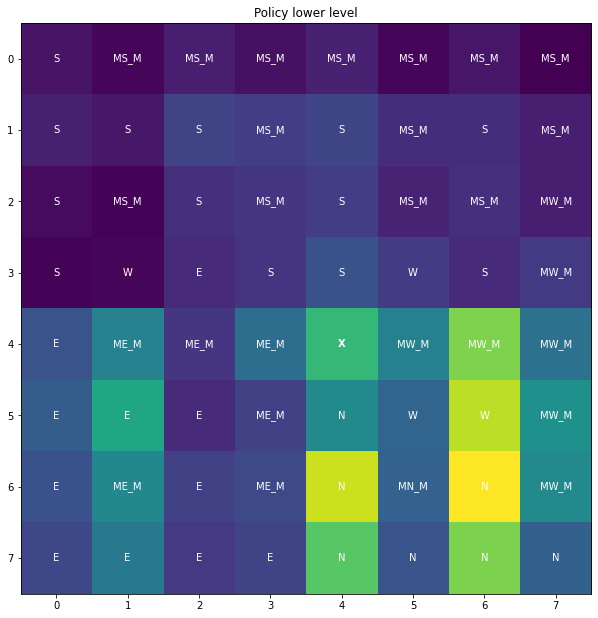

cccc
Learn 5.12
Init 5.01
Nil 5.27
Exact 5.17


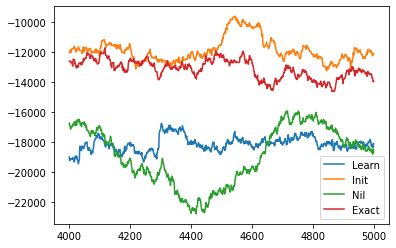

Learn 5.12
Init 5.01
Nil 5.27
Exact 5.17


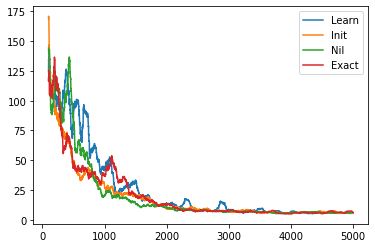

Learn -49.71
Init -25.74
Nil -45.42
Exact -26.78


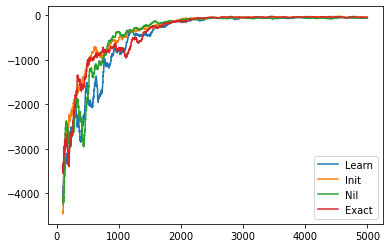

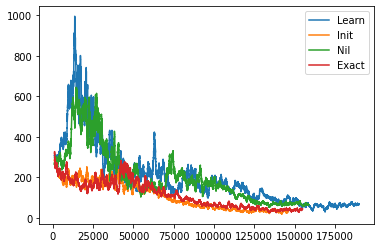

In [23]:
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    nn=r_dict_6[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print_policy(nn, env4, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    
    print(labelp,pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_6[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    
    print(labelp,pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    print(labelp,pd.Series(r_dict_6[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_6[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    pd.Series(r_dict_6[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Init 22.200158096338033
Nil 22.88762447284077
Exact 19.986174420386465
Learn 25.51496598204514


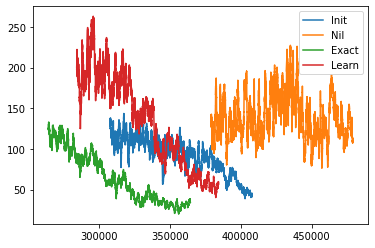

In [122]:
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().tail(100000).plot(label=labelp)
    print(labelp,pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().min())
plt.legend()

In [64]:
np.array([pd.Series(r_dict_3[x]['losses']) for x in range(4)])

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0           0.944539
1           4.000000
2         116.894913
3           0.962077
4           0.956444
             ...    
395262      1.541258
395263      4.000000
395264      8.323048
395265     36.082764
395266      7.426988
Length: 395267, dtype: float64,
       0           0.868928
1           0.853750
2           8.439255
3         121.108536
4           0.979999
             ...    
354883      1.000000
354884      0.233869
354885      5.187146
354886     46.029171
354887      6.011152
Length: 354888, dtype: float64,
       0           1.006482
1           1.007505
2           9.000000
3         117.600548
4           0.837997
             ...    
377156     13.437597
377157      3.808572
377158    231.068237
377159     29.945692
377160     15.245069
Length: 377161, dtype: float64,
       0           0.972997
1           4.000000
2         121.008476
3           0.829128
4           3.806385
             ...    
392085    179.027435
392086      1.000000
392087      8.5

In [23]:
pd.Series(losses).rolling(999).mean().tail(1).values[0]

96.32986692258063

In [24]:
import collections

In [25]:
a=collections.Counter([tuple(x) for x in ss])

<AxesSubplot:>

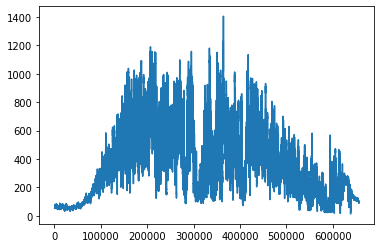

In [26]:
pd.Series(losses).rolling(500).mean().plot()

In [27]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [24]:
for e in [env1,env2,env3]:
    plt.imshow(e.maze())

#

NameError: name 'env1' is not defined

In [27]:
env2

NameError: name 'env2' is not defined

In [29]:
Q_policy.man_layer.weight


Parameter containing:
tensor([[ 0.0246, -0.4764, -0.5448]], requires_grad=True)

In [30]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([-0.3883], grad_fn=<AddBackward0>)
tensor([-0.8894], grad_fn=<AddBackward0>)
tensor([-0.9577], grad_fn=<AddBackward0>)


In [31]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8885

In [32]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [33]:
PATH = "C:/Users/howar/AppData/Local/Programs/netron"
torch.save(Q_policy.state_dict(), os.path.join(PATH,"filename.pth"))

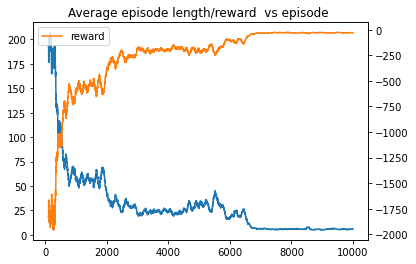

In [15]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [16]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8739

In [17]:
pd.Series(episode_durations).rolling(100).mean().min()

4.97

In [18]:
pd.Series(rewards).rolling(100).mean().max()

-23.61

In [19]:
pd.Series(rewards).rolling(100).mean().idxmax()

9525

In [20]:
a=pd.Series(rewards).rolling(100).mean()-pd.Series(rewards).rolling(100).mean().shift(-100)

In [89]:
a.tail(3000).idxmin()

7326

<AxesSubplot:>

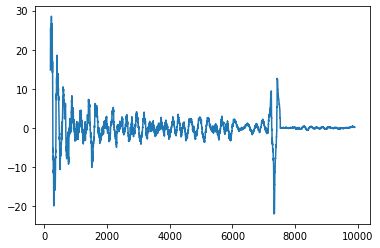

In [90]:
a.diff().rolling(100).mean().plot()

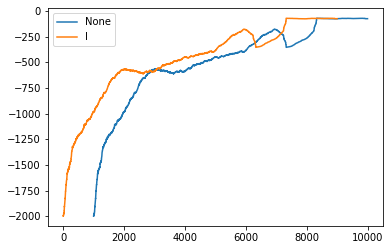

In [91]:
pd.Series(rewards).rolling(1000).mean().plot()
pd.Series(rewards).rolling(1000).mean().shift(-1000).plot(label='l')
plt.legend()

In [92]:
pd.Series(rewards).rolling(100).mean().max()

-53.25

In [93]:
pd.Series(rewards).rolling(50).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
9995   -73.68
9996   -73.98
9997   -73.98
9998   -74.94
9999   -75.36
Length: 10000, dtype: float64

In [127]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[ 0.0246, -0.5033, -0.5646]], requires_grad=True)